# Supervised Learning Capstone Project
## What variables are most predictive of a client's difficulty to pay back their loans?
---
By Sebastian Rosado Mustafa

## Introduction: Banking the Unbanked

People around the world struggle to secure loans because of scarce or non-existent credit histories. This population is also at risk of being taken advantage of by predatory lenders.

[Home Credit](https://www.homecreditus.com/) is a financial institution that 'strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience.'* To accomplish this, they use big data. Home Credit leverages unconventonial and fascinating datapoints (such as living room size and the creditworthiness of your social circle) to predict a client's ability to repay a loan.

They have open-sourced their raw data on Kaggle so machine learning enthusiasts and experts give their best shot at extracting all of its potential. This is an excellent opportunity to work with real data that can have a tangible impact on people's lives and generate tremendous business value.

In this notebook, I will use two of the tables Home Credit released for two purposes:

1. Minimizing unforeseen payment delays and defaults by minimizing my algorithm's false negative rate / type II error (AKA increasing recall). In a loan business, where cash flows can be so unpredictable, it is of value to make them as _predictable_ as possible. To accomplish this, we must minimize instances where a client is incorrectly classified as 0 (no payment difficulties) when he/she was in fact 1 (payment difficulties).
2. Determining the variables that are most predictive of a client's difficulty to pay back their loans.

This data amounts to hundreds of thousands of rows, and hundreds of columns. And we're only using two tables, of **seven** that Home Credit released. A supervised learning algorithm like the one I will select and train can help humans in this industry take advantage of this massive amount of data to help people financially and to strengthen their business. This is for the credit unions, the banks, the landlords, the car dealerships and the online lenders. Most of all, however, it is for the client. Where people need a loan to move forward in life, data can now help them get it.

*[Kaggle Contest Post by Home Credit](https://www.kaggle.com/c/home-credit-default-risk/overview)

![caption](schema.png)

The yellow contours indicate the tables that will be used.

### It all began with 'import pandas'...

In [1]:
import pandas as pd
import numpy as np
current_state = np.random.get_state()
np.random.set_state(current_state)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy import stats
from scipy.stats import ttest_ind
import time 
import random

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Changing default table display options

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [3]:
# Importing DataFrames

app_train = pd.read_csv('../storage/application_train.csv')
app_test = pd.read_csv('../storage/application_test.csv')
hc_desc = pd.read_csv('../storage/HomeCredit_columns_description.csv', encoding='latin_1')

# Data Descriptions
From the [Kaggle](https://www.kaggle.com/c/home-credit-default-risk/overview) Post:

### app_train / app_test: 
_'The main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample.'_

### bureau:
_'All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.'_

### hc_desc:
_'This file contains descriptions for the columns in the various data files.'_

In [4]:
# Checking dimensions

print('Size of app_train data:', app_train.shape)
print('Size of app_test data:', app_test.shape)
print('Size of hc_desc data:', hc_desc.shape)

Size of app_train data: (307511, 122)
Size of app_test data: (48744, 121)
Size of hc_desc data: (219, 5)


Since these dataframe are quite large, we will conduct EDA on them separately to keep things manageable.

# EDA

## Data Structure & Distributions

In [5]:
app_test.shape

(48744, 121)

In [6]:
app_train.shape

(307511, 122)

In [7]:
# Merging train and test sets

app_train['TYPE'] = 'train'
app_test['TYPE'] = 'test'

# Concatenating train & test sets

app = pd.concat([app_train, app_test], axis = 0)

In [8]:
app.shape

(356255, 123)

In [9]:
app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 123 entries, SK_ID_CURR to TYPE
dtypes: float64(66), int64(40), object(17)
memory usage: 337.0+ MB


In [10]:
# TARGET value will be NaN, which is fine for now

app[app['TYPE'] == 'test'].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TYPE
0,100001,NaN,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,test
1,100005,NaN,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,test
2,100013,NaN,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,test
3,100028,NaN,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Wo

In [11]:
app['TARGET'].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

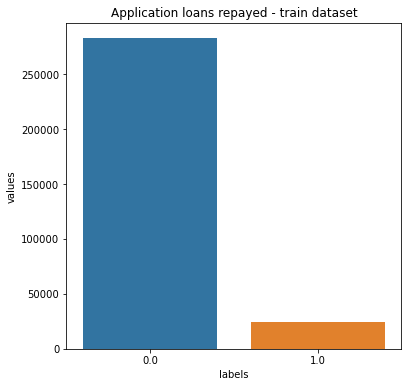

In [12]:
# Extremely imbalanced data, will affect our supervised learning parameters

temp = app['TARGET'].value_counts()
target_graph = pd.DataFrame({'labels':temp.index,
                   'values':temp.values    
})

plt.figure(figsize=(6,6))

plt.title('Application loans repayed - train dataset')

sns.set_color_codes('pastel')
sns.barplot(x=target_graph['labels'], y=target_graph['values'])
locs, labels = plt.xticks()

plt.show()

### Column Descriptions

In [13]:
# Description of application table features
pd.set_option('display.max_colwidth', 1000)

# Getting description table for 'app' only
app_desc = hc_desc[hc_desc['Table'] == 'application_{train|test}.csv'][['Row', 'Description']]

app_desc.head()

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car


In [14]:
# Renaming 'Row' as 'Column'
app_desc = app_desc.rename(columns= {'Row': 'Column'})

# Sorting values alphabetically by column name
descriptions = app_desc.sort_values('Column', ascending=True)

descriptions.reset_index()

descriptions

,Column,Description
9,AMT_ANNUITY,Loan annuity
8,AMT_CREDIT,Credit amount of the loan
10,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given
7,AMT_INCOME_TOTAL,Income of the client
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)
116,AMT_REQ_CREDIT_BUREAU_HOUR,Number of enquiries to Credit Bureau about the client one hour before application
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application)
121,AMT_REQ_CREDIT_BUREAU_YEAR,Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)


- Days birth, EXT_SOURCE_1, HOUR_APPR_PROCESS_START all seem roughly normally distributed. This seems normal in the case of Days_birth and HOUR_APPR_PROCESS_START. There is no reason to expect EXT_SOURCE_1 to be normally distributed or not.
- Most of our variables measuring average, modal and median sizes for various parts of the buildings where borrowers live are heavily skewed right (perhaps not surprising. If we assume size correlated with how wealthy you are, the wealthier you are, the less of a need there is to apply for home credit. Also, perhaps the smaller your home, the higher the incentive to apply for a home loan to move to a bigger one).
- Years variables measuring building age are skewed left. For reasons above, again not that surprising. Many of these buildings are on the older end of the spectrum.
- We'll take a closer look at continuous variables for potential outliers.

In [15]:
app.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,307511.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,121014.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356253.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,162345.000000,3.555870e+05,286622.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,185200.000000,355205.000000,355205.000000,355205.000000,355205.000000,356254.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.00000,356255.000000,356255.000000,356255.000000,356255.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000
mean,278128.000000,0.080729,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,-4983.593527,-3002.071163,12.023741,0.999994,0.818498,0.200098,0.998170,0.278612,0.071213,2.151858,2.050506,2.028932,12.055749,0.015649,0.051371,0.040847,0.078076,0.229661,0.178824,0.501965,5.148900e-01,0.509350,0.118138,0.088673,0.977889,0.752283,0.045045,0.079819,0.150015,0.227331,0.232817,0.066454,0.101495,0.108089,0.008868,0.028503,0.114914,0.087750,0.977239,0.759452,0.042930,0.075346,0.145471,0.223315,0.228878,0.065092,0.106382,0.106641,0.008116,0.027183,0.118549

- CNT_CHILDREN: More than 75% of the applicant population has less than one child. At least one applicant has 19 children. This is a definite outlier, but it may be interesting to explore its relation to payment difficulties.
- Total applicant income's max value may be an outlier.
- Annuity's max value is much higher than average.
- Relative region population's minimum value is very low.
- One or more people are registered to have worked for over 1000 years. Definite outlier to look into.
- One or more people seem to have a 91 year-old car.
- CNT_FAM_MEMBERS seems to have an outlier.

## Missing Values & Duplicates

In [16]:
# Checking for duplicate values

app.duplicated().sum()

0

No observable duplicate rows.

In [17]:
# Creating a function for displaying missing values

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.reset_index()
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table_ren_columns.rename(columns= {'index': 'Column', 0: 'Missing Values', 1: '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [18]:
missing_values_table(app)

Your selected dataframe has 123 columns.
There are 68 columns that have missing values.


,Column,Missing Values,% of Total Values
48,COMMONAREA_AVG,248360,69.7
76,COMMONAREA_MEDI,248360,69.7
62,COMMONAREA_MODE,248360,69.7
84,NONLIVINGAPARTMENTS_MEDI,246861,69.3
70,NONLIVINGAPARTMENTS_MODE,246861,69.3
56,NONLIVINGAPARTMENTS_AVG,246861,69.3
86,FONDKAPREMONT_MODE,243092,68.2
82,LIVINGAPARTMENTS_MEDI,242979,68.2
54,LIVINGAPARTMENTS_AVG,242979,68.2
68,LIVINGAPARTMENTS_MODE,242979,68.2


In [19]:
# Since we have over 350k rows, we'll drop rows with small amounts of nulls with little effect

app.dropna(subset=['DAYS_LAST_PHONE_CHANGE',
                   'CNT_FAM_MEMBERS',
                   'AMT_ANNUITY',
                   'AMT_GOODS_PRICE',
                   'EXT_SOURCE_2',
                   'DEF_60_CNT_SOCIAL_CIRCLE',
                   'DEF_30_CNT_SOCIAL_CIRCLE',
                   'OBS_60_CNT_SOCIAL_CIRCLE',
                   'OBS_30_CNT_SOCIAL_CIRCLE',
                   'AMT_REQ_CREDIT_BUREAU_YEAR',
                   'AMT_REQ_CREDIT_BUREAU_HOUR',
                   'AMT_REQ_CREDIT_BUREAU_QRT',
                   'AMT_REQ_CREDIT_BUREAU_MON',
                   'AMT_REQ_CREDIT_BUREAU_DAY',
                   'AMT_REQ_CREDIT_BUREAU_WEEK',
                   'NAME_TYPE_SUITE'], inplace=True)

In [20]:
missing_values_table(app)

Your selected dataframe has 123 columns.
There are 52 columns that have missing values.


,Column,Missing Values,% of Total Values
76,COMMONAREA_MEDI,211745,69.4
62,COMMONAREA_MODE,211745,69.4
48,COMMONAREA_AVG,211745,69.4
70,NONLIVINGAPARTMENTS_MODE,210398,68.9
84,NONLIVINGAPARTMENTS_MEDI,210398,68.9
56,NONLIVINGAPARTMENTS_AVG,210398,68.9
86,FONDKAPREMONT_MODE,207212,67.9
68,LIVINGAPARTMENTS_MODE,207080,67.8
82,LIVINGAPARTMENTS_MEDI,207080,67.8
54,LIVINGAPARTMENTS_AVG,207080,67.8


In [21]:
# Drop columns with 30% or more nulls and the rows on EXT_SOURCE_3.

# Assign table to variable

col_drop = missing_values_table(app)

Your selected dataframe has 123 columns.
There are 52 columns that have missing values.


In [22]:
# Filter for the appropriate values

col_drop = list(col_drop[col_drop['% of Total Values'] >= 30]['Column'])

In [23]:
# Drop

app.drop(columns = col_drop, inplace = True)

In [24]:
# Drop Rows on EXT_SOURCE_3

app.dropna(subset=['EXT_SOURCE_3'], inplace=True)

In [25]:
# Glance at new shape

app.shape

(283550, 73)

In [26]:
# Confirm that only TARGET still has missing values

missing_values_table(app)

Your selected dataframe has 73 columns.
There are 1 columns that have missing values.


,Column,Missing Values,% of Total Values
1,TARGET,39270,13.8


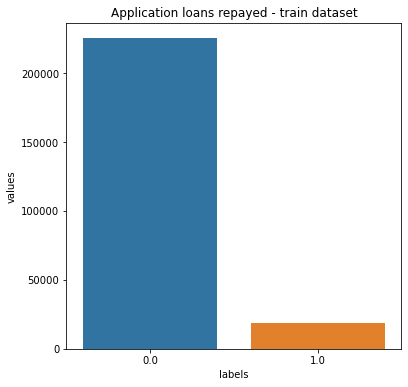

In [27]:
# Data is actually more balanced now

temp = app['TARGET'].value_counts()
target_graph = pd.DataFrame({'labels':temp.index,
                   'values':temp.values    
})

plt.figure(figsize=(6,6))

plt.title('Application loans repayed - train dataset')

sns.set_color_codes('pastel')
sns.barplot(x=target_graph['labels'], y=target_graph['values'])
locs, labels = plt.xticks()

plt.show()

### Categorical variables pt. 1: visualizing correlations

In [28]:
# Getting a sense of how many values per datatype

app.dtypes.value_counts()

int64      40
float64    21
object     12
dtype: int64

In [29]:
# Checking the number of unique values in each categorical variable to understand encoding opportunities
# and limitations.

app.select_dtypes('object').apply(pd.Series.nunique, axis=0).sort_values(ascending=False)

ORGANIZATION_TYPE             58
WEEKDAY_APPR_PROCESS_START     7
NAME_INCOME_TYPE               7
NAME_TYPE_SUITE                7
NAME_HOUSING_TYPE              6
NAME_FAMILY_STATUS             5
NAME_EDUCATION_TYPE            5
CODE_GENDER                    3
TYPE                           2
FLAG_OWN_REALTY                2
FLAG_OWN_CAR                   2
NAME_CONTRACT_TYPE             2
dtype: int64

In [30]:
app.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE', 'TYPE'],
      dtype='object')

In [31]:
# Categorical variables are also found as int64s

app.select_dtypes(include='int64').columns

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

We will get a feel for the data by visualizing only a few of these variables.

In [32]:
# Visualization function

def plot_category(feature, label_rotation=False):
    
    print('Description of {0}: {1}'.format(feature, descriptions[descriptions['Column'] == feature]['Description']))
    
    # Set up the data for the count plot
    category_unique = app[feature].value_counts()
    category_counts = pd.DataFrame({feature: category_unique.index, 'Number of loans': category_unique.values})
    
    # Set up the data to calculate the payment difficulty rate per category
    category_percent = app[[feature, 'TARGET']].groupby([feature], as_index=False).mean()
    category_percent.sort_values(by='TARGET', ascending=False, inplace=True)
    
    # Creating the layout for the tables     
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))
    
    # Plotting the category_counts table     
    s = sns.barplot(ax=ax1, x=feature, y='Number of loans', data=category_counts, palette = colors)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=70)
    
    # Plotting the '% with payment difficulty' table     
    s = sns.barplot(ax=ax2, x=feature, y='TARGET', data=category_percent, palette = colors)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=70)
    plt.ylabel('% with Payment Difficulties')
    
    plt.show()

Description of CODE_GENDER: 3    Gender of the client
Name: Description, dtype: object


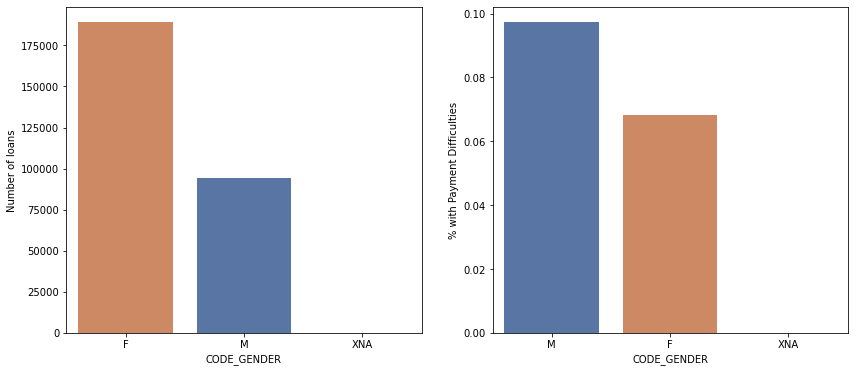

In [33]:
colors = {'M': '#4c72b0',
          'F': '#dd8452',
          'XNA': '#55a868',
          }

plot_category('CODE_GENDER')

In [34]:
app['CODE_GENDER'].value_counts()

F      189092
M       94454
XNA         4
Name: CODE_GENDER, dtype: int64

In [35]:
# We have an undefined category in the gender column. We'll drop it

app = app[app['CODE_GENDER'] != 'XNA']

In [36]:
# Making colors match according to variables

colors = {'M': '#4C72B0', 'F': '#DD8452'}

Description of CODE_GENDER: 3    Gender of the client
Name: Description, dtype: object


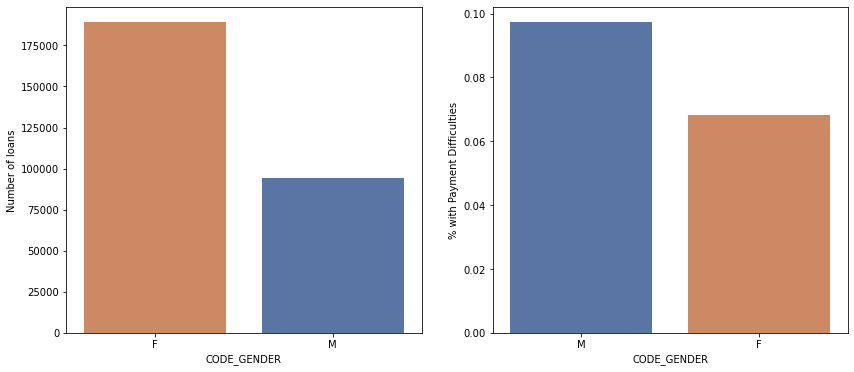

In [37]:
plot_category('CODE_GENDER')

Description of NAME_CONTRACT_TYPE: 2    Identification if loan is cash or revolving
Name: Description, dtype: object


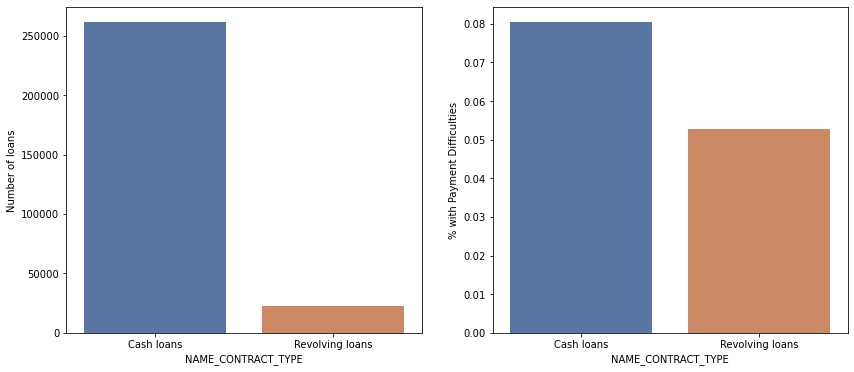

In [38]:
colors = {'Cash loans': '#4C72B0', 'Revolving loans': '#DD8452'}

plot_category('NAME_CONTRACT_TYPE')

Many more clients cash loans than with revolving loans, and those with cash loans are more likely to be late on one or more of their payments.

Description of FLAG_OWN_CAR: 4    Flag if the client owns a car
Name: Description, dtype: object


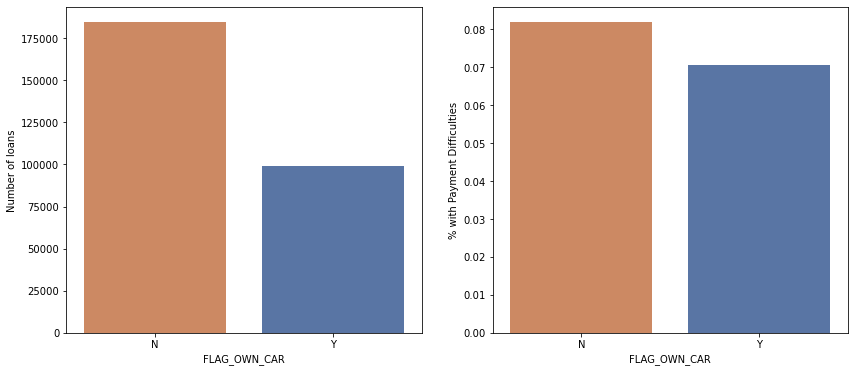

In [39]:
colors = {'N': '#DD8452', 'Y': '#4C72B0'}

plot_category('FLAG_OWN_CAR')

Higher rates of missed payment dates for people that don't have a car. Additionally, at least in our sample, more people without cars are applying for home credit.

Description of FLAG_OWN_REALTY: 5    Flag if client owns a house or flat
Name: Description, dtype: object


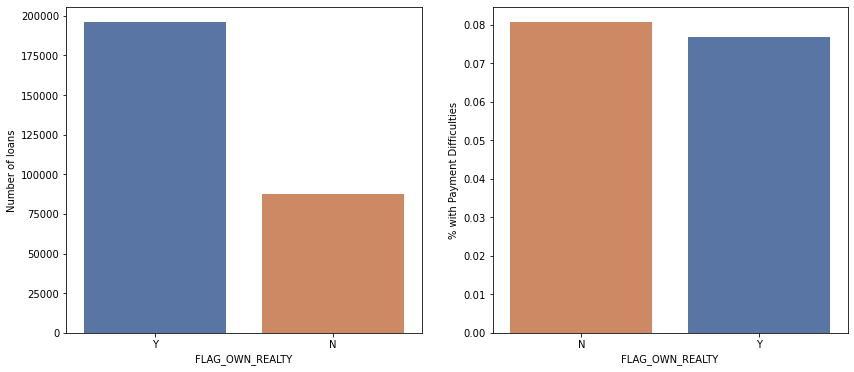

In [40]:
plot_category('FLAG_OWN_REALTY')

In [41]:
pal = sns.color_palette("deep")
print(pal.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


Description of NAME_TYPE_SUITE: 11    Who was accompanying client when he was applying for the loan
Name: Description, dtype: object


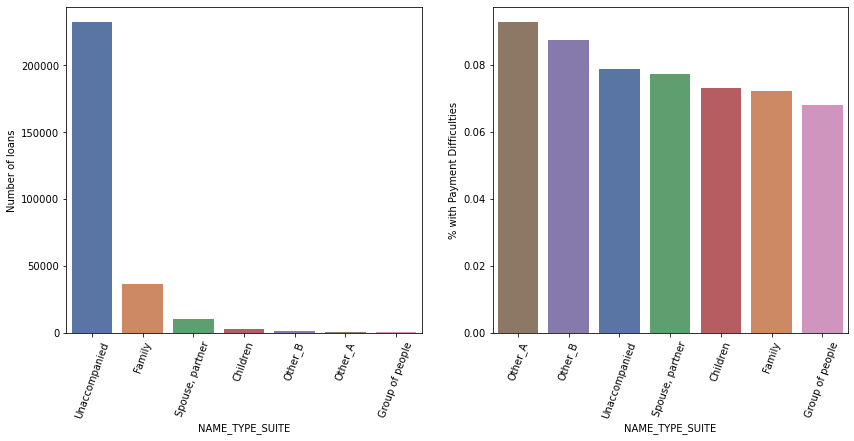

In [42]:
colors = {'Unaccompanied': '#4c72b0',
          'Family': '#dd8452',
          'Spouse, partner': '#55a868',
          'Children': '#c44e52',
          'Other_B': '#8172b3',
          'Other_A': '#937860',
          'Group of people': '#da8bc3'}

plot_category('NAME_TYPE_SUITE', label_rotation=True)

No description of what of what the 'Other' categories are, but it seems like being accompanied by family or groups of people is associated with lower difficulty paying back loans. So far these differences are minor.

Description of NAME_INCOME_TYPE: 12    Clients income type (businessman, working, maternity leave,)
Name: Description, dtype: object


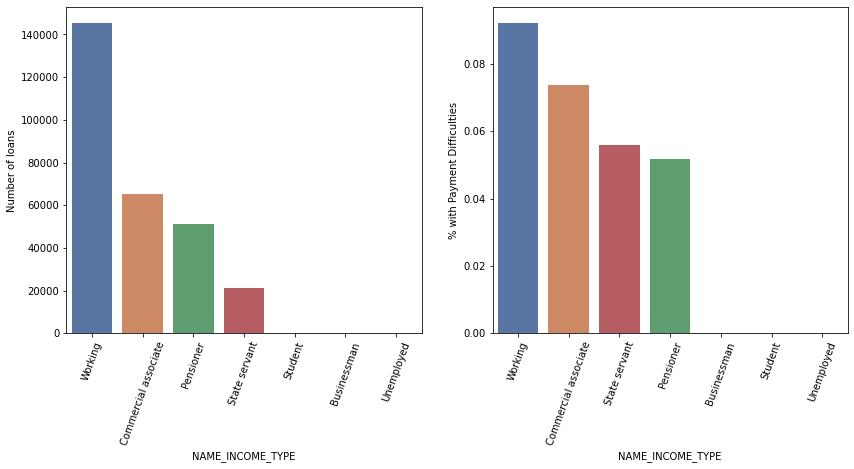

In [43]:
colors = {'Working': '#4c72b0',
          'Commercial associate': '#dd8452',
          'Pensioner': '#55a868',
          'State servant': '#c44e52',
          'Student': '#8172b3',
          'Businessman': '#937860',
          'Unemployed': '#da8bc3'}

plot_category('NAME_INCOME_TYPE', label_rotation=True)

In [44]:
# Very few of some categories.

app.NAME_INCOME_TYPE.value_counts()

Working                 145519
Commercial associate     65207
Pensioner                51445
State servant            21355
Student                     13
Businessman                  5
Unemployed                   2
Name: NAME_INCOME_TYPE, dtype: int64

Description of NAME_EDUCATION_TYPE: 13    Level of highest education the client achieved
Name: Description, dtype: object


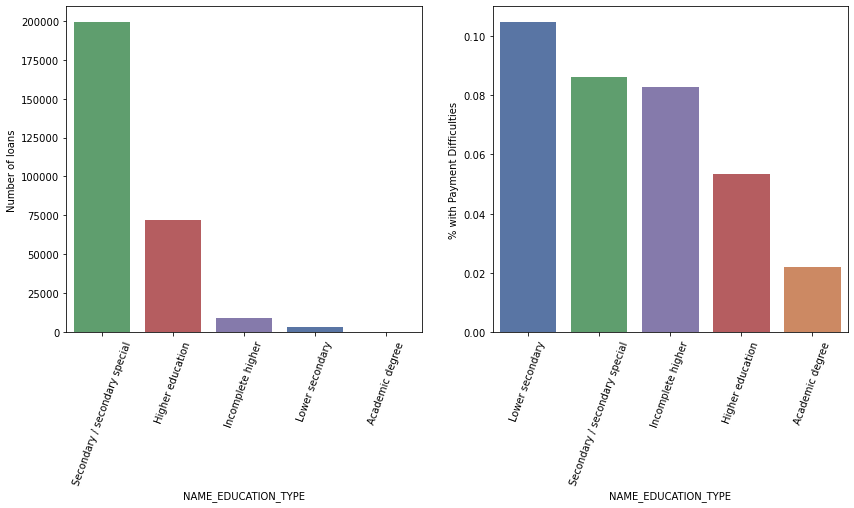

In [45]:
colors = {'Secondary / secondary special': '#55a868',
          'Higher education': '#c44e52',
          'Incomplete higher': '#8172b3',
          'Lower secondary': '#4c72b0',
          'Academic degree': '#dd8452'
          }

plot_category('NAME_EDUCATION_TYPE', label_rotation=True)

Description of NAME_FAMILY_STATUS: 14    Family status of the client
Name: Description, dtype: object


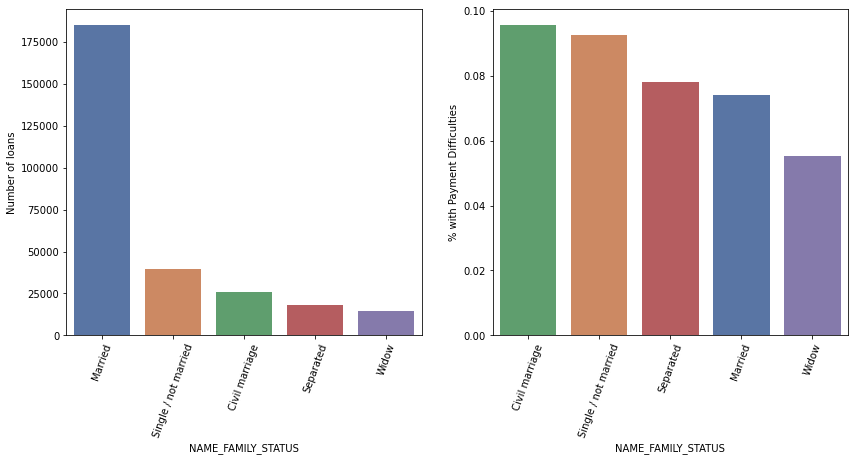

In [46]:
colors = {'Married': '#4c72b0',
          'Single / not married': '#dd8452',
          'Civil marriage': '#55a868',
          'Separated': '#c44e52',
          'Widow': '#8172b3',
         }

plot_category('NAME_FAMILY_STATUS', label_rotation=True)

Description of NAME_HOUSING_TYPE: 15    What is the housing situation of the client (renting, living with parents, ...)
Name: Description, dtype: object


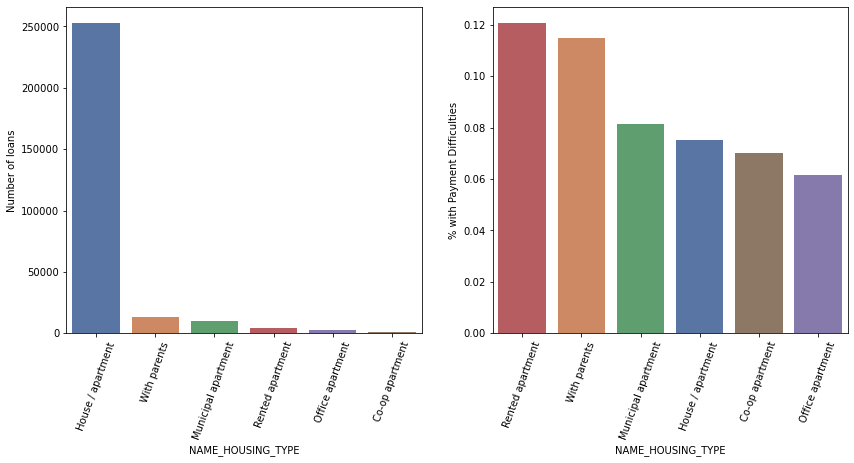

In [47]:
colors = {'House / apartment': '#4c72b0',
          'With parents': '#dd8452',
          'Municipal apartment': '#55a868',
          'Rented apartment': '#c44e52',
          'Office apartment': '#8172b3',
          'Co-op apartment': '#937860',
          }

plot_category('NAME_HOUSING_TYPE', label_rotation=True)

Description of WEEKDAY_APPR_PROCESS_START: 32    On which day of the week did the client apply for the loan
Name: Description, dtype: object


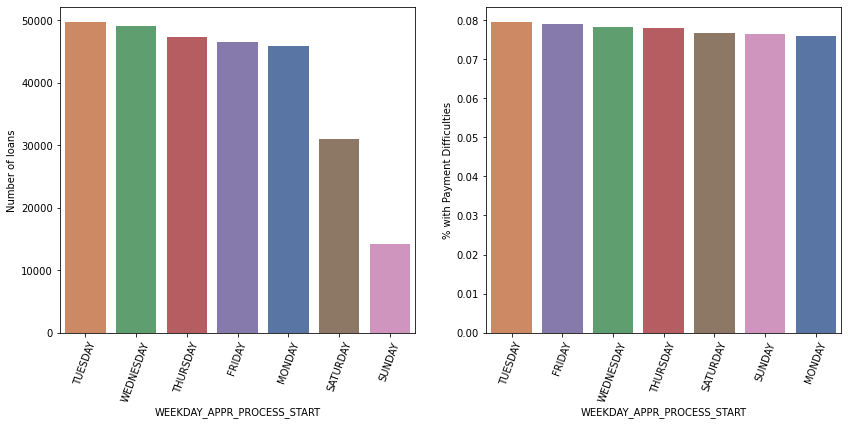

In [48]:
colors = {'MONDAY': '#4c72b0',
          'TUESDAY': '#dd8452',
          'WEDNESDAY': '#55a868',
          'THURSDAY': '#c44e52',
          'FRIDAY': '#8172b3',
          'SATURDAY': '#937860',
          'SUNDAY': '#da8bc3'}

plot_category('WEEKDAY_APPR_PROCESS_START', label_rotation=True)

Description of REGION_RATING_CLIENT_W_CITY: 31    Our rating of the region where client lives with taking city into account (1,2,3)
Name: Description, dtype: object


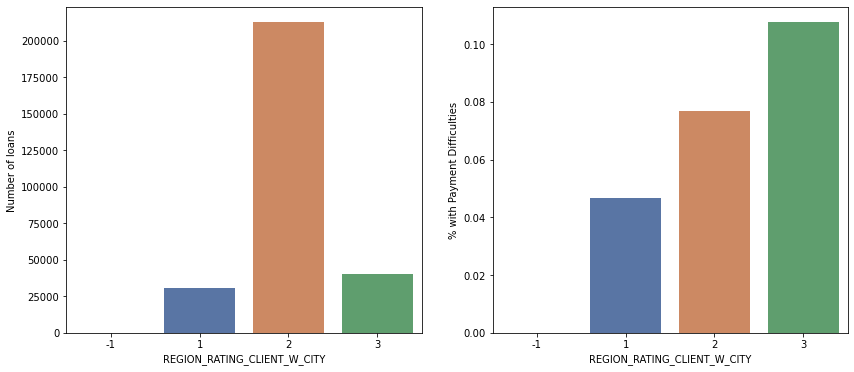

In [49]:
colors = {1: '#4c72b0',
          2: '#dd8452',
          3: '#55a868',
          -1: '#c44e52',
          }

plot_category('REGION_RATING_CLIENT_W_CITY')

Rating variables shouldn't have negative values. We'll drop the extraneous values.

In [50]:
# Only one negative value.

app['REGION_RATING_CLIENT_W_CITY'].value_counts()

 2    212672
 3     40009
 1     30864
-1         1
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

In [51]:
# Dropping out the negative value

app = app[app['REGION_RATING_CLIENT_W_CITY'] != -1]

In [52]:
# Confirming the drop

app['REGION_RATING_CLIENT_W_CITY'].value_counts()

2    212672
3     40009
1     30864
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64

In [53]:
# Adjusting parameters to display larger graph

def plot_category(feature, label_rotation=False):
    
    print('Description of {0}: {1}'.format(feature, descriptions[descriptions['Column'] == feature]['Description']))
    
    # Set up the data for the count plot
    category_unique = app[feature].value_counts()
    category_counts = pd.DataFrame({feature: category_unique.index, 'Number of loans': category_unique.values})
    
    # Set up the data to calculate the payment difficulty rate per category
    category_percent = app[[feature, 'TARGET']].groupby([feature], as_index=False).mean()
    category_percent.sort_values(by='TARGET', ascending=False, inplace=True)
    
    # Creating the layout for the tables     
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 20))
    
    # Color styling
    sns.set_color_codes('deep')
    
    # Plotting the category_counts table     
    s = sns.barplot(ax=ax1, x=feature, y='Number of loans', data=category_counts)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=70)
    
    # Plotting the '% with payment difficulty' table     
    s = sns.barplot(ax=ax2, x=feature, y='TARGET', data=category_percent)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=70)
    plt.ylabel('% with Payment Difficulties')
    fig.subplots_adjust(hspace=.5)
    
    plt.show()

Description of ORGANIZATION_TYPE: 40    Type of organization where client works
Name: Description, dtype: object


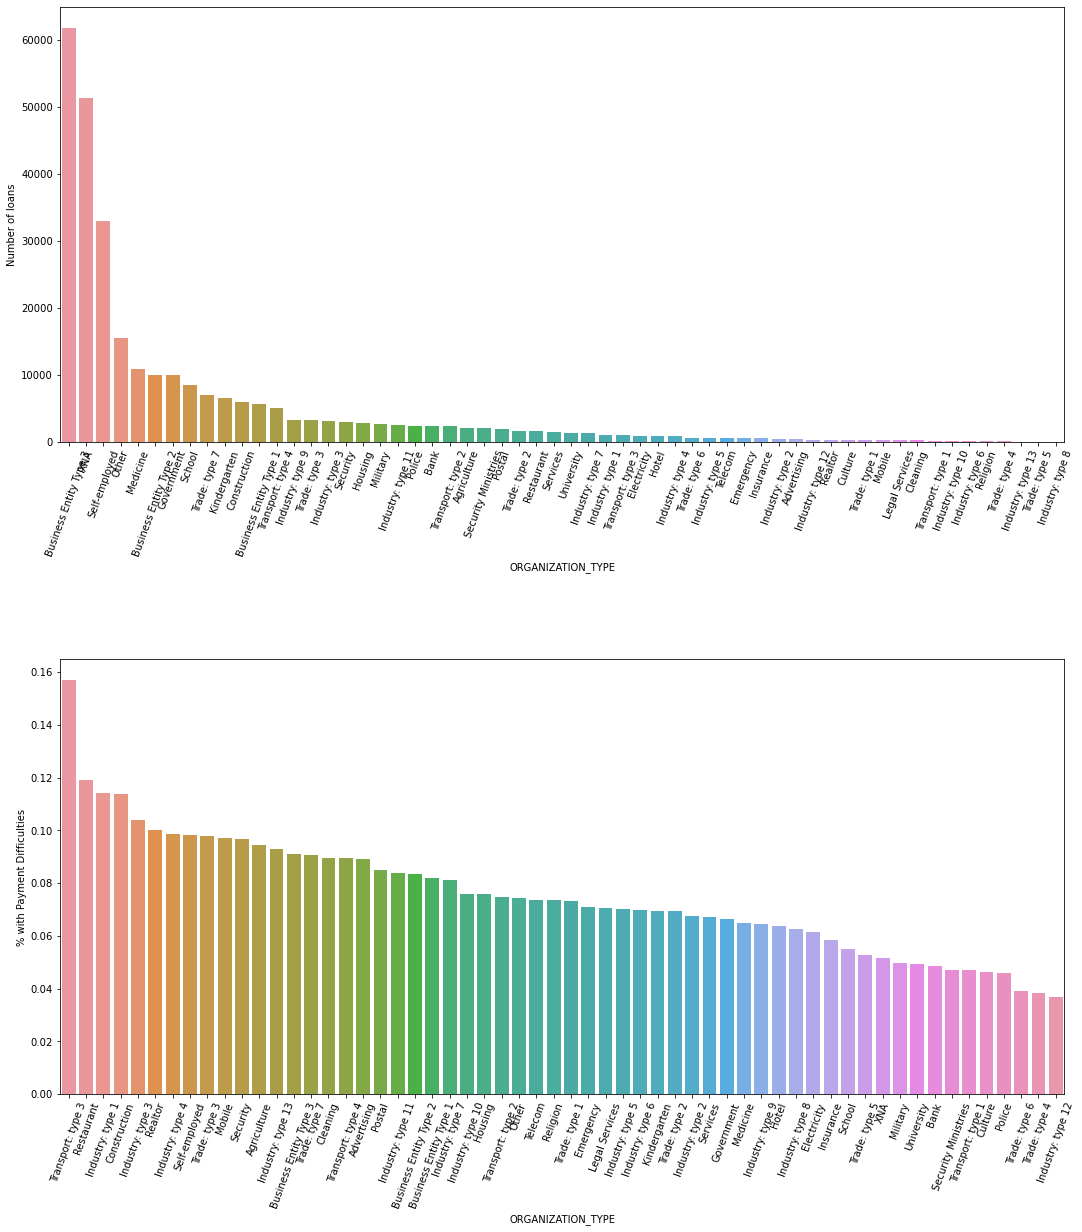

In [54]:
plot_category('ORGANIZATION_TYPE', label_rotation=True)

### Categorical Variables Pt. 2: One-Hot Encoding

To avoid the problem of having our model interpret the integers assigned to categories through label encoding as having relative value when they do not, I will one-hot encode all categorical variables, even if they have a relatively small number of unique values.

Given, as is repeated below, that we have categorical variables with as many as 58 unique values, our number of columns will be very large after one-hot encoding. To deal with this, I will apply PCA to reduce the number of dimensions while still preserving information.

In [55]:
# Drop-first true not working

app = pd.get_dummies(app, drop_first=True)

In [56]:
app.shape

(283545, 154)

In [57]:
app.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE

### Continuous variables pt. 1: outliers

In [58]:
continuous = app.select_dtypes(include=['float64'])

print(continuous.columns)
print('\n')
print(app.dtypes.value_counts())

Index(['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')


uint8      93
int64      40
float64    21
dtype: int64


In [59]:
# Removing target from DataFrame
continuous.drop(columns = 'TARGET', inplace=True)

In [60]:
# Converting DataFrame to list
continuous_labels = list(continuous.columns)

In [61]:
# Adding discrete non-binary variables to the continuous_labels list

integer = app.select_dtypes(include=['int64'])

integer = integer.columns

In [62]:
integer_list = list(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START'])

In [63]:
continuous_labels += integer_list

In [64]:
len(continuous_labels)

25

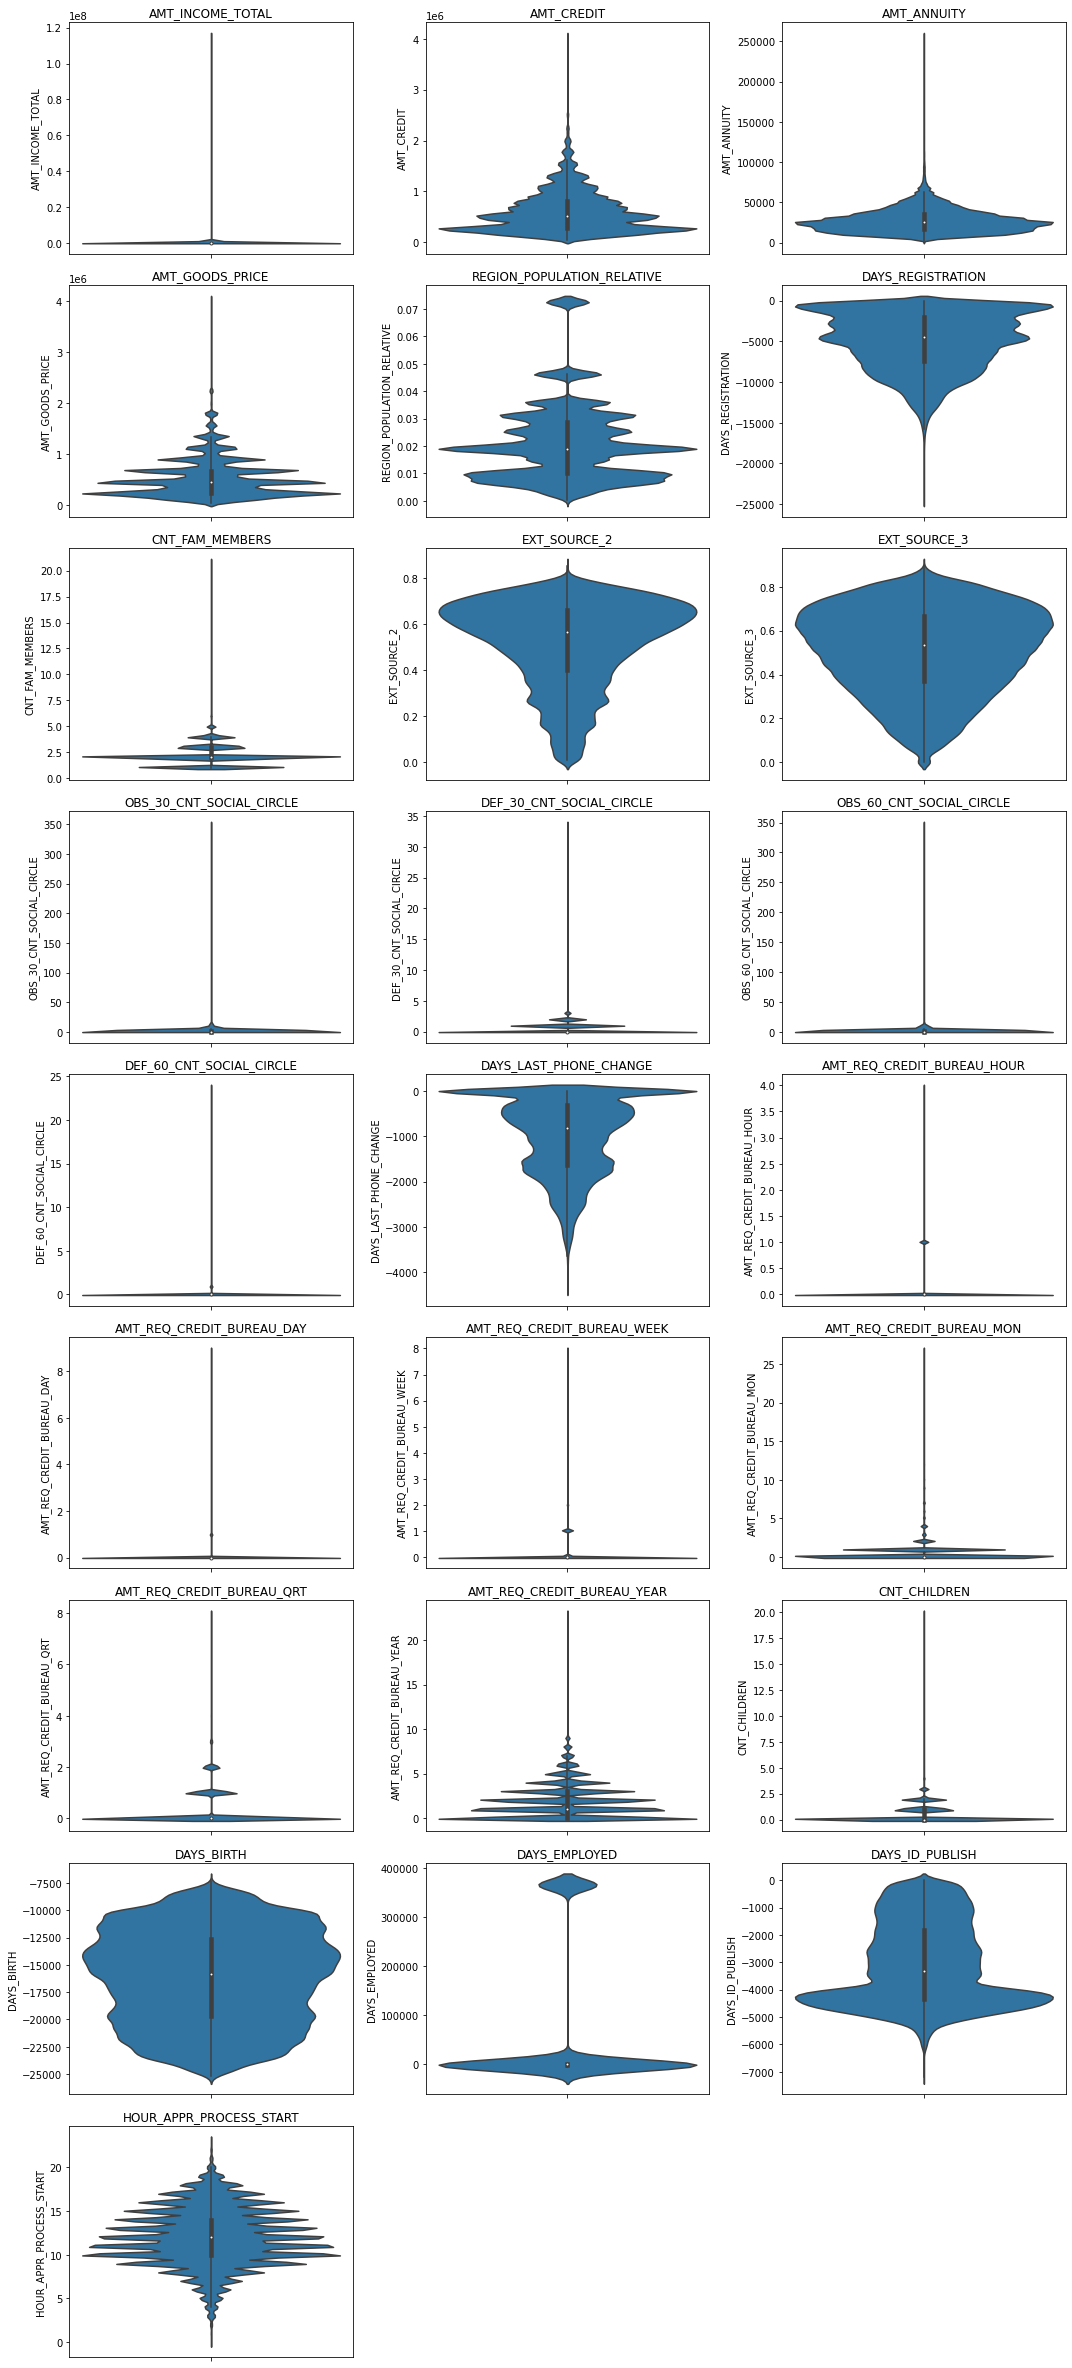

In [65]:

i = 1
plt.figure(figsize=(15,33))

for var in continuous_labels:
    plt.subplot(9,3,i)
    sns.violinplot(app[var], scale='width', orient='v')
    sns.set_color_codes('bright')
    plt.title(var)
    i+=1

plt.tight_layout()
plt.show()

We have a lot of variables with outliers. In general, I won't manipulate them unless I feel there is a need to do so after running some learning models on the dataset. However, DAYS_EMPLOYED and REGION_POPULATION RELATIVE show an unusually high concentration of specific outliers values. I will look more into those two for now.

In [66]:
print(descriptions[descriptions['Column'] == 'REGION_POPULATION_RELATIVE']['Description'])

app.REGION_POPULATION_RELATIVE.value_counts().sort_values(ascending=False)

16    Normalized population of region where client lives (higher number means the client lives in more populated region)
Name: Description, dtype: object


0.035792    15378
0.046220    12032
0.030755    11414
0.025164    10919
0.031329    10533
0.026392    10524
0.028663    10177
0.019101     8210
0.072508     7630
0.018850     7104
0.020246     6866
0.020713     6798
0.018634     6658
0.015221     6475
0.022625     6396
0.032561     5923
0.024610     5892
0.018209     5809
0.018801     5680
0.019689     5573
0.018029     5333
0.014520     4460
0.016612     4092
0.007020     3913
0.022800     3626
0.010006     3493
0.010032     3313
0.011703     3142
0.004960     3079
0.010966     2858
0.014464     2853
0.011657     2839
0.010147     2820
0.010643     2795
0.007120     2737
0.007330     2655
0.010500     2529
0.009175     2440
0.006629     2426
0.009657     2321
0.010276     2319
0.008625     2212
0.010556     2083
0.009630     2062
0.009334     1985
0.006852     1915
0.007305     1881
0.006207     1820
0.003069     1771
0.009549     1763
0.006008     1753
0.008230     1708
0.008019     1701
0.008474     1697
0.008575     1672
0.007274  

Judging from the description of the variable, I will chalk this one up to inhabitants of larger towns and won't pursue it further. Let's look at DAYS_EMPLOYED.

Text(0.5, 1.0, 'Days employed at moment of loan request')

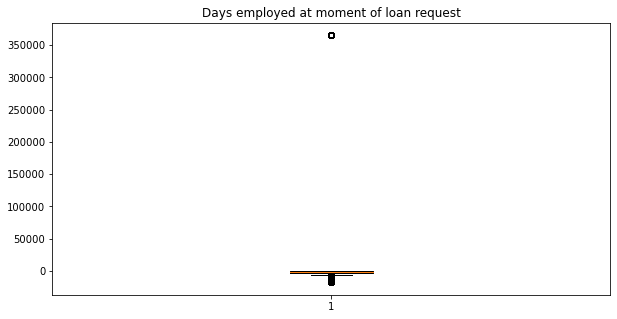

In [67]:
# The min value is a standalone extreme outlier.

plt.figure(figsize = (10,5))
plt.boxplot(app['DAYS_EMPLOYED'])
plt.title("Days employed at moment of loan request")

In [68]:
print(descriptions[descriptions['Column'] == 'DAYS_EMPLOYED']['Description'])

print()

print(app.DAYS_EMPLOYED.value_counts().sort_values(ascending=False))

print()

print(app['DAYS_EMPLOYED'].describe())

18    How many days before the application the person started current employment
Name: Description, dtype: object

 365243    51440
-199         146
-200         141
-229         129
-224         128
           ...  
-13351         1
-10275         1
-9504          1
-12322         1
-12038         1
Name: DAYS_EMPLOYED, Length: 12585, dtype: int64

count    283545.000000
mean      64220.584299
std      141728.922533
min      -17912.000000
25%       -2903.000000
50%       -1291.000000
75%        -306.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


A whopping 51,440 people are logged as having worked over 1000 years prior to their loan application. Maybe these outliers have something in common. Let's see how they perform on their loans.

In [69]:
employment_outliers = app[app['DAYS_EMPLOYED'] == 365243]

employment_normal = app[app['DAYS_EMPLOYED'] != 365243]

print('Employment outliers fell behind on %0.2f%% of their loans' % (100 * employment_outliers['TARGET'].mean()))

print('Employment normals fell behind on %0.2f%% of their loans' % (100 * employment_normal['TARGET'].mean()))

Employment outliers fell behind on 5.17% of their loans
Employment normals fell behind on 8.37% of their loans


It seems like employment outliers are actually better loan payers. I'll fill in these outliers as nulls and fill them in grouping by one of our categorical variables.

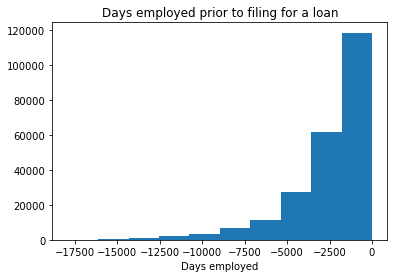

In [70]:
# Creating outlier boolean
app['EMPLOYMENT_OUTLIERS'] = app['DAYS_EMPLOYED'] == 365243

app.drop(columns='EMPLOYMENT_OUTLIERS', inplace=True)

# replacing values with nan
app['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace =True)

plt.hist(app['DAYS_EMPLOYED'])
plt.title('Days employed prior to filing for a loan')
plt.xlabel('Days employed')
plt.show()

In [71]:
missing_values_table(app)

Your selected dataframe has 154 columns.
There are 2 columns that have missing values.


,Column,Missing Values,% of Total Values
9,DAYS_EMPLOYED,51440,18.1
1,TARGET,39269,13.8


Text(0.5, 1.0, 'Days employed per regional / city rating')

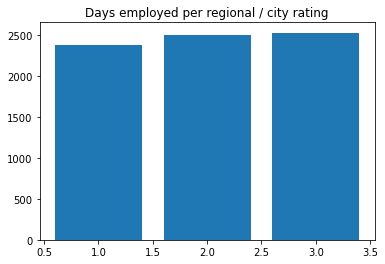

In [72]:
# Trying to find categorical associations for a more precise imputation

# Converting days employed to its absolute
app['DAYS_EMPLOYED'] = abs(app['DAYS_EMPLOYED'])

# Grouping data by regional / city rating
days_employed = app.groupby('REGION_RATING_CLIENT_W_CITY')['DAYS_EMPLOYED'].mean().sort_values()

# Converting index to a column
days_employed = days_employed.reset_index()

# Sorting values
days_employed.sort_values('REGION_RATING_CLIENT_W_CITY', ascending = False)

# Quick plot
plt.bar(days_employed['REGION_RATING_CLIENT_W_CITY'], days_employed['DAYS_EMPLOYED'])
plt.title('Days employed per regional / city rating')

Better ratings seem to be weakly associated to more days employed. We'll put off imputation to see if we find a better variable to group by in the the bureau dataset, coming up.

### Continuous Variables Pt. 2 - Visualizing Correlations

In [73]:
# Finding correlations with our target, and sorting
correlations = app.corr()['TARGET'].sort_values()

print('Most positive correlations:\n', correlations.tail(15))
print('\n')
print('Most negative correlations:\n', correlations.head(15))

Most positive correlations:
 REG_CITY_NOT_LIVE_CITY                               0.043892
FLAG_EMP_PHONE                                       0.045768
NAME_EDUCATION_TYPE_Secondary / secondary special    0.046744
DAYS_ID_PUBLISH                                      0.049078
REG_CITY_NOT_WORK_CITY                               0.049933
CODE_GENDER_M                                        0.051369
DAYS_LAST_PHONE_CHANGE                               0.051971
REGION_RATING_CLIENT                                 0.054506
NAME_INCOME_TYPE_Working                             0.054988
REGION_RATING_CLIENT_W_CITY                          0.056533
DAYS_BIRTH                                           0.079132
TARGET                                               1.000000
FLAG_MOBIL                                                NaN
FLAG_DOCUMENT_2                                           NaN
TYPE_train                                                NaN
Name: TARGET, dtype: float64


Most negat

DAYS_BIRTH is the most positive correlation. This variable indicates how old, in days, the applicant was at the time of his application for a loan. As with days employed above, the variable measures days negatively from the day of application. This in fact means that the less days old you are (lower negative number), the more likely you are to miss one or more payments on your loan (i.e. target == 1). In other words, the older you are, the less likely you are to miss payments on your loan.

The same logic applies to DAYS_ID_PUBLISH (how many days prior to application the applicant changed his application document) and DAYS_LAST_PHONE_CHANGE. In order to avoid confusion, we will convert these variables to their absolute value.

It also seems like you're least likely to miss payments on your loan if you've gone through higher education. The same principle holds if you're a pensioner.

In [74]:
app['DAYS_BIRTH'] = abs(app['DAYS_BIRTH'])

app['DAYS_ID_PUBLISH'] = abs(app['DAYS_ID_PUBLISH'])

app['DAYS_LAST_PHONE_CHANGE'] = abs(app['DAYS_LAST_PHONE_CHANGE'])

print(app['DAYS_BIRTH'].corr(app['TARGET']))

print(app['DAYS_EMPLOYED'].corr(app['TARGET']))

print(app['DAYS_ID_PUBLISH'].corr(app['TARGET']))

print(app['DAYS_LAST_PHONE_CHANGE'].corr(app['TARGET']))

-0.0791319665455032
-0.0752394632763219
-0.04907844085461288
-0.05197129631301245


Being older, working longer and having the same ID and phone for longer are associated with lower likelihood that you'll have trouble paying back your loans.

In [75]:
# Most applicants have changed their phone quite recently.
# Do younger people might switch phones more often?
# Weak positive association

from scipy.stats import pearsonr

print(pearsonr(app['DAYS_BIRTH'], app['DAYS_LAST_PHONE_CHANGE']))

(0.07667084186591822, 0.0)


Text(0.5, 1.0, 'Loan repayment by age distribution')

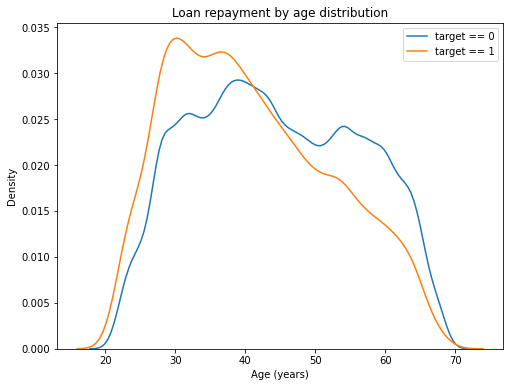

In [76]:
plt.figure(figsize=(8, 6))

# KDE plot of laons that were repaid on time
sns.kdeplot(app[app['TARGET']==0]['DAYS_BIRTH']/365,
           label = 'target == 0')

# KDE plot of loans that were not repaid on time
sns.kdeplot(app[app['TARGET']==1]['DAYS_BIRTH']/365,
           label = 'target == 1')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Loan repayment by age distribution')

Clients with trouble making their loan payments on time are disproportionately represented by people on the younger end of the spectrum. Let's look at this relationship broken down by age brackets.

In [77]:
# Filter age information

age_data = app[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# And binning it

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(
20, 70, num = 11))
age_data.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1.0,9461,25.920548,"(25.0, 30.0]"
2,0.0,19046,52.180822,"(50.0, 55.0]"
5,0.0,16941,46.413699,"(45.0, 50.0]"
6,0.0,13778,37.747945,"(35.0, 40.0]"
7,0.0,18850,51.643836,"(50.0, 55.0]"


In [78]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.128310,8561.812170,23.457020
"(25.0, 30.0]",0.109371,10173.539958,27.872712
"(30.0, 35.0]",0.097756,11860.894909,32.495602
"(35.0, 40.0]",0.087956,13710.196051,37.562181
"(40.0, 45.0]",0.076059,15493.690348,42.448467
"(45.0, 50.0]",0.072755,17327.497929,47.472597
"(50.0, 55.0]",0.064435,19194.061044,52.586469
"(55.0, 60.0]",0.052210,20985.721785,57.495128
"(60.0, 65.0]",0.050597,22775.227448,62.397883


Text(0.5, 1.0, 'Payment difficulties by age group (%)')

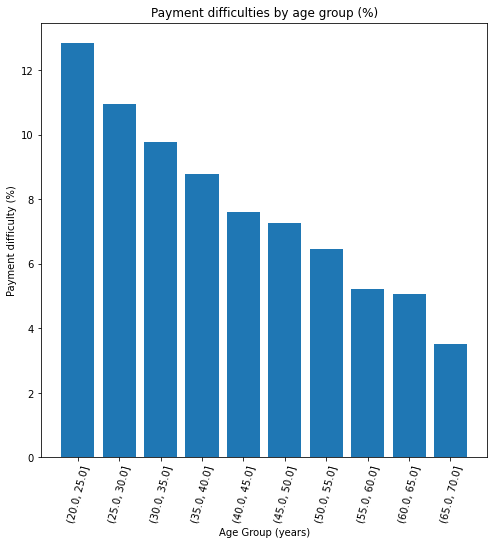

In [79]:
plt.figure(figsize=(8, 8))

# Graph the age bins and the average of the target
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75)
plt.xlabel('Age Group (years)')
plt.ylabel('Payment difficulty (%)')
plt.title('Payment difficulties by age group (%)')

The table suggests that younger applicants are more likely to have trouble paying back their loans. Let's look at negative correlations.

Ext_source is described as 'normalized score from external data source'. That description is not very illustrative but let's look at a heatmap.

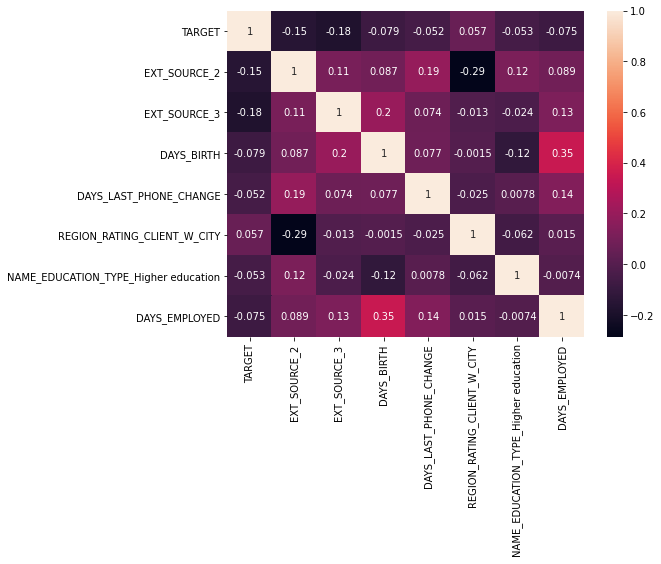

In [80]:
ext_group = app[['TARGET',
                 'EXT_SOURCE_2',
                 'EXT_SOURCE_3',
                 'DAYS_BIRTH',
                 'DAYS_LAST_PHONE_CHANGE',
                 'REGION_RATING_CLIENT_W_CITY',
                 'NAME_EDUCATION_TYPE_Higher education',
                 'DAYS_EMPLOYED']]

ext_group_corrs = ext_group.corr()

plt.figure(figsize = (8, 6))
sns.heatmap(ext_group_corrs, annot=True)
plt.show()

Days_birth has a fairly strong correlation with ext_source_3, as does 'region rating client w city' with ext_source_2, suggesting that perhaps those variables were included in the creation these 'external data sources'. Let's visualize the EXT sources.

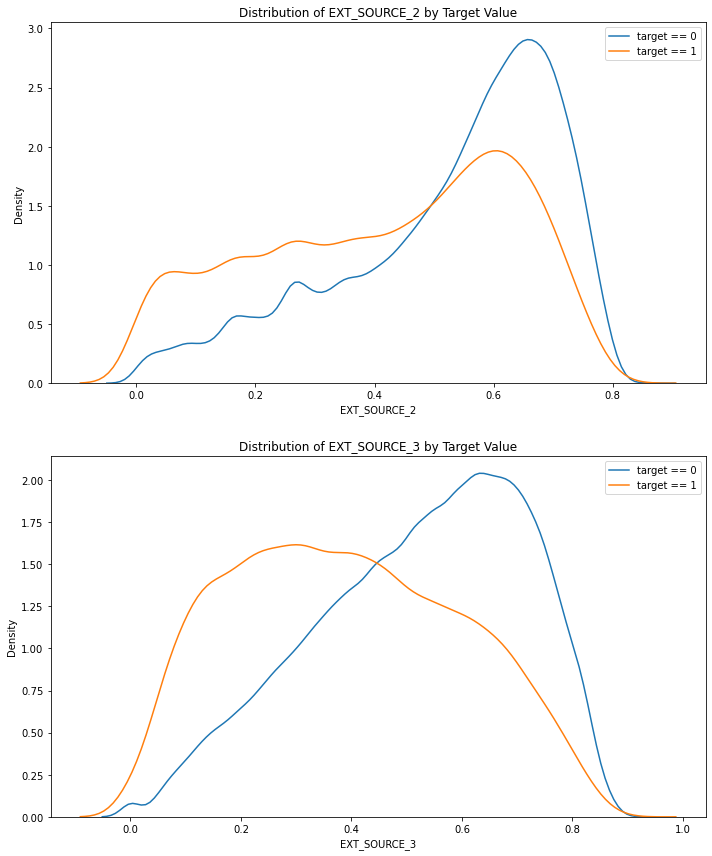

In [81]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
#     Subplot for each source
      plt.subplot(2, 1, i + 1)
#     plot repaid loans
      sns.kdeplot(app.loc[app['TARGET'] == 0, source],
           label = 'target == 0')
#     plot loans for which payments were missed
      sns.kdeplot(app.loc[app['TARGET'] == 1, source],
            label = 'target == 1')

      plt.title('Distribution of {} by Target Value'.format(source))
      plt.xlabel('{}'.format(source))
      plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)

Sources 1 and 3 show the greatest distribution difference between payers and non-payers of loans, although 3 is distorted.

We'll bring in the 'bureau.csv' dataset, explore it, clean it, merge it with 'app' and go on to feature engineering.

# Introducing bureau.csv

As a reminder, the Kaggle post describes this DataFrame as:

_'All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.'_

The fact that this table has a one-to-many relationship means we will have to condense observations so that SK_ID_CURR values are unique in the table before merging with app.

In [82]:
bureau = pd.read_csv('../storage/bureau.csv')

In [83]:
bureau.shape

(1716428, 17)

In [84]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [85]:
bureau.head(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.00,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.00,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.00,71017.38,108982.62,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.80,42103.80,0.00,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.00,0.00,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.00,0.00,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.00,0.00,0.0,Credit card,-690,NaN


One applicant ID leads to one or more past loans. Before we merge this table with our first one, we will have to group features together by SK_ID_CURR. Otherwise we will get ID repeats upon merging.

In [86]:
bureau_desc = hc_desc[hc_desc['Table'] == 'bureau.csv'][['Row', 'Description']]
bureau_desc = bureau_desc.rename(columns= {'Row': 'Column'})

bureau_desc

,Column,Description
122,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau"
123,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
124,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
125,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
126,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit
127,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample
128,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit
129,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit)
130,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
131,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged


In [87]:
bureau.duplicated().sum()

0

In [88]:
missing_values_table(bureau)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Column,Missing Values,% of Total Values
16,AMT_ANNUITY,1226791,71.5
8,AMT_CREDIT_MAX_OVERDUE,1124488,65.5
7,DAYS_ENDDATE_FACT,633653,36.9
12,AMT_CREDIT_SUM_LIMIT,591780,34.5
11,AMT_CREDIT_SUM_DEBT,257669,15.0
6,DAYS_CREDIT_ENDDATE,105553,6.1
10,AMT_CREDIT_SUM,13,0.0


Dropping rows on DAYS_CREDIT_ENDDATE, AMT_CREDIT_SUM and AMT_CREDIT_SUM_DEBT, dropping all other columns with nulls

In [89]:
# Add in 'AMT_ANNUITY' in the end

# Dropping

bureau.drop(columns=['DAYS_ENDDATE_FACT', 'AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_LIMIT'], inplace = True)

In [90]:
bureau.dropna(subset=['DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT'], inplace = True)


# Confirming it has been done
bureau.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376391 entries, 0 to 1716426
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_CURR              1376391 non-null  int64  
 1   SK_ID_BUREAU            1376391 non-null  int64  
 2   CREDIT_ACTIVE           1376391 non-null  object 
 3   CREDIT_CURRENCY         1376391 non-null  object 
 4   DAYS_CREDIT             1376391 non-null  int64  
 5   CREDIT_DAY_OVERDUE      1376391 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     1376391 non-null  float64
 7   CNT_CREDIT_PROLONG      1376391 non-null  int64  
 8   AMT_CREDIT_SUM          1376391 non-null  float64
 9   AMT_CREDIT_SUM_DEBT     1376391 non-null  float64
 10  AMT_CREDIT_SUM_OVERDUE  1376391 non-null  float64
 11  CREDIT_TYPE             1376391 non-null  object 
 12  DAYS_CREDIT_UPDATE      1376391 non-null  int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 147.0+ M

In [91]:
missing_values_table(bureau)

Your selected dataframe has 13 columns.
There are 0 columns that have missing values.


,Column,Missing Values,% of Total Values


I want to do three things with this dataset before merging. I will group by applicant and:
1. Get counts of how many loans were issued per applicant
2. Condense continuous variables into summary statistics
3. Get sums and means of categorical variables

1. Get counts of how many loans were issued per applicant Will test for correlation to target later on

In [92]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'PREVIOUS_LOAN_COUNTS'})

previous_loan_counts

,SK_ID_CURR,PREVIOUS_LOAN_COUNTS
0,100001,7
1,100002,3
2,100003,4
3,100004,2
4,100005,3
...,...,...
294717,456249,9
294718,456250,3
294719,456253,4
294720,456254,1


2. Condense continuous variables into summary statistics

In [93]:
# We'll convert DAYS_CREDIT_UPDATE and DAYS_CREDIT to absolute value for the sake of consistency with 'DAYS'
# variables before.
# DAYS_CREDIT_ENDDATE has both negative and positive numbers, so we'll leave it as is.

print(bureau['CREDIT_DAY_OVERDUE'].unique()[:10])
print(bureau['DAYS_CREDIT_UPDATE'].unique())
print(bureau['DAYS_CREDIT_ENDDATE'].unique())
print(bureau['DAYS_CREDIT'].unique())

[   0 2603    6   30  186   41    8   71   13  252]
[  -131    -20    -31 ...  -2901 -41918  -2844]
[ -153.  1075. 27460. ...  3835.  9607.  5650.]
[-497 -208 -273 ...    0   -3   -1]


In [94]:
bureau['DAYS_CREDIT_UPDATE'] = abs(bureau['DAYS_CREDIT_UPDATE'])
bureau['DAYS_CREDIT'] = abs(bureau['DAYS_CREDIT'])

In [95]:
bureau_stats = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(['count',
                                                                                      'mean',
                                                                                      'max',
                                                                                      'min',
                                                                                      'sum']).reset_index()

bureau_stats.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean   max  min   sum              count   
0     100001           7   735.000000  1572   49  5145                  7   
1     100002           3  1041.333333  1437  645  3124                  3   
2     100003           4  1400.750000  2586  606  5603                  4   
3     100004           2   867.000000  1326  408  1734                  2   
4     100005           3   190.666667   373   62   572                  3   

                   DAYS_CREDIT_ENDDATE                                      \
  mean max min sum               count        mean     max     min     sum   
0  0.0   0   0   0                   7   82.428571  1778.0 -1329.0   577.0   
1  0.0   0   0   0                   3  -69.000000   780.0 -1072.0  -207.0   
2  0.0   0   0   0                   4 -544.500000  1216.0 -2434.0 -2178.0   
3  0.0   0   0   0                   2 -488.500000  -382.0  -595.0  -977.0   
4  0.0   0   0   0                   3  439.333333  1324.0  -128.0  1318.0   

  CNT_CREDIT_PROLONG                  AMT_CREDIT_SUM                           \
               count mean max min sum          count           mean       max   
0                  7  0.0   0   0   0              7  207623.571429  378000.0   
1                  3  0.0   0   0   0              3  235245.000000  450000.0   
2                  4  0.0   0   0   0              4  254350.125000  810000.0   
3                  2  0.0   0   0   0              2   94518.900000   94537.8   
4                  3  0.0   0   0   0              3  219042.000000  568800.0   

                       AMT_CREDIT_SUM_DEBT                                \
        min        sum               count           mean       max  min   
0   85500.0  1453365.0                   7   85240.928571  373239.0  0.0   
1  120735.0   705735.0                   3   81927.000000  245781.0  0.0   
2   22248.0  1017400.5                   4       0.000000       0.0  0.0   
3   94500.0   189037.8                   2       0.000000       0.0  0.0   
4   29826.0   657126.0                   3  189469.500000  543087.0  0.0   

            AMT_CREDIT_SUM_OVERDUE                     DAYS_CREDIT_UPDATE  \
        sum                  count mean  max  min  sum              count   
0  596686.5                      7  0.0  0.0  0.0  0.0                  7   
1  245781.0                      3  0.0  0.0  0.0  0.0                  3   
2       0.0                      4  0.0  0.0  0.0  0.0                  4   
3       0.0                      2  0.0  0.0  0.0  0.0                  2   
4  568408.5                      3  0.0  0.0  0.0  0.0                  3   

                                
         mean   max  min   sum  
0   93.142857   155    6   652  
1  408.666667  1185    7  1226  
2  816.000000  2131   43  3264  
3  532.000000   682  382  1064  
4   54.333333   121   11   163

We'll make each individual stat a column with its origin feature as a suffix.

In [96]:
bureau_stats.columns

MultiIndex([(            'SK_ID_CURR',      ''),
            (           'DAYS_CREDIT', 'count'),
            (           'DAYS_CREDIT',  'mean'),
            (           'DAYS_CREDIT',   'max'),
            (           'DAYS_CREDIT',   'min'),
            (           'DAYS_CREDIT',   'sum'),
            (    'CREDIT_DAY_OVERDUE', 'count'),
            (    'CREDIT_DAY_OVERDUE',  'mean'),
            (    'CREDIT_DAY_OVERDUE',   'max'),
            (    'CREDIT_DAY_OVERDUE',   'min'),
            (    'CREDIT_DAY_OVERDUE',   'sum'),
            (   'DAYS_CREDIT_ENDDATE', 'count'),
            (   'DAYS_CREDIT_ENDDATE',  'mean'),
            (   'DAYS_CREDIT_ENDDATE',   'max'),
            (   'DAYS_CREDIT_ENDDATE',   'min'),
            (   'DAYS_CREDIT_ENDDATE',   'sum'),
            (    'CNT_CREDIT_PROLONG', 'count'),
            (    'CNT_CREDIT_PROLONG',  'mean'),
            (    'CNT_CREDIT_PROLONG',   'max'),
            (    'CNT_CREDIT_PROLONG',   'min'),
            (    'CN

In [97]:
# We get a blank because SK_ID_CURR level[1] has not stat

print(bureau_stats.columns.levels[1][:])

print('\n')
# Quick fix

print(bureau_stats.columns.levels[1][:-1])

Index(['count', 'mean', 'max', 'min', 'sum', ''], dtype='object')


Index(['count', 'mean', 'max', 'min', 'sum'], dtype='object')


In [98]:
# Assigning column names to a variable

stat_columns = ['SK_ID_CURR']

for var in bureau_stats.columns.levels[0]:
    
    if var != 'SK_ID_CURR':
        
        for stat in bureau_stats.columns.levels[1][:-1]:
            
            stat_columns.append('bureau_%s_%s' % (var, stat))


In [99]:
bureau_stats.columns = stat_columns

bureau_stats.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum
0,100001,7,735.000000,1572,49,5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.0,7,85240.928571,373239.0,0.0,596686.5,7,0.0,0.0,0.0,0.0,7,93.142857,155,6,652
1,100002,3,1041.333333,1437,645,3124,3,0.0,0,0,0,3,-69.000000,780.0,-1072.0,-207.0,3,0.0,0,0,0,3,235245.000000,450000.0,120735.0,705735.0,3,81927.000000,245781.0,0.0,245781.0,3,0.0,0.0,0.0,0.0,3,408.666667,1185,7,1226
2,100003,4,1400.750000,2586,606,5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.5,4,0.000000,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,4,816.000000,2131,43,3264
3,100004,2,867.000000,1326,408,1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.8,2,0.000000,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,2,532.000000,682,382,1064
4,100005,3,190.666667,373,62,572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.0,3,189469.500000,543087.0,0.0,568408.5,3,0.0,0.0,0.0,0.0,3,54.333333,121,11,163


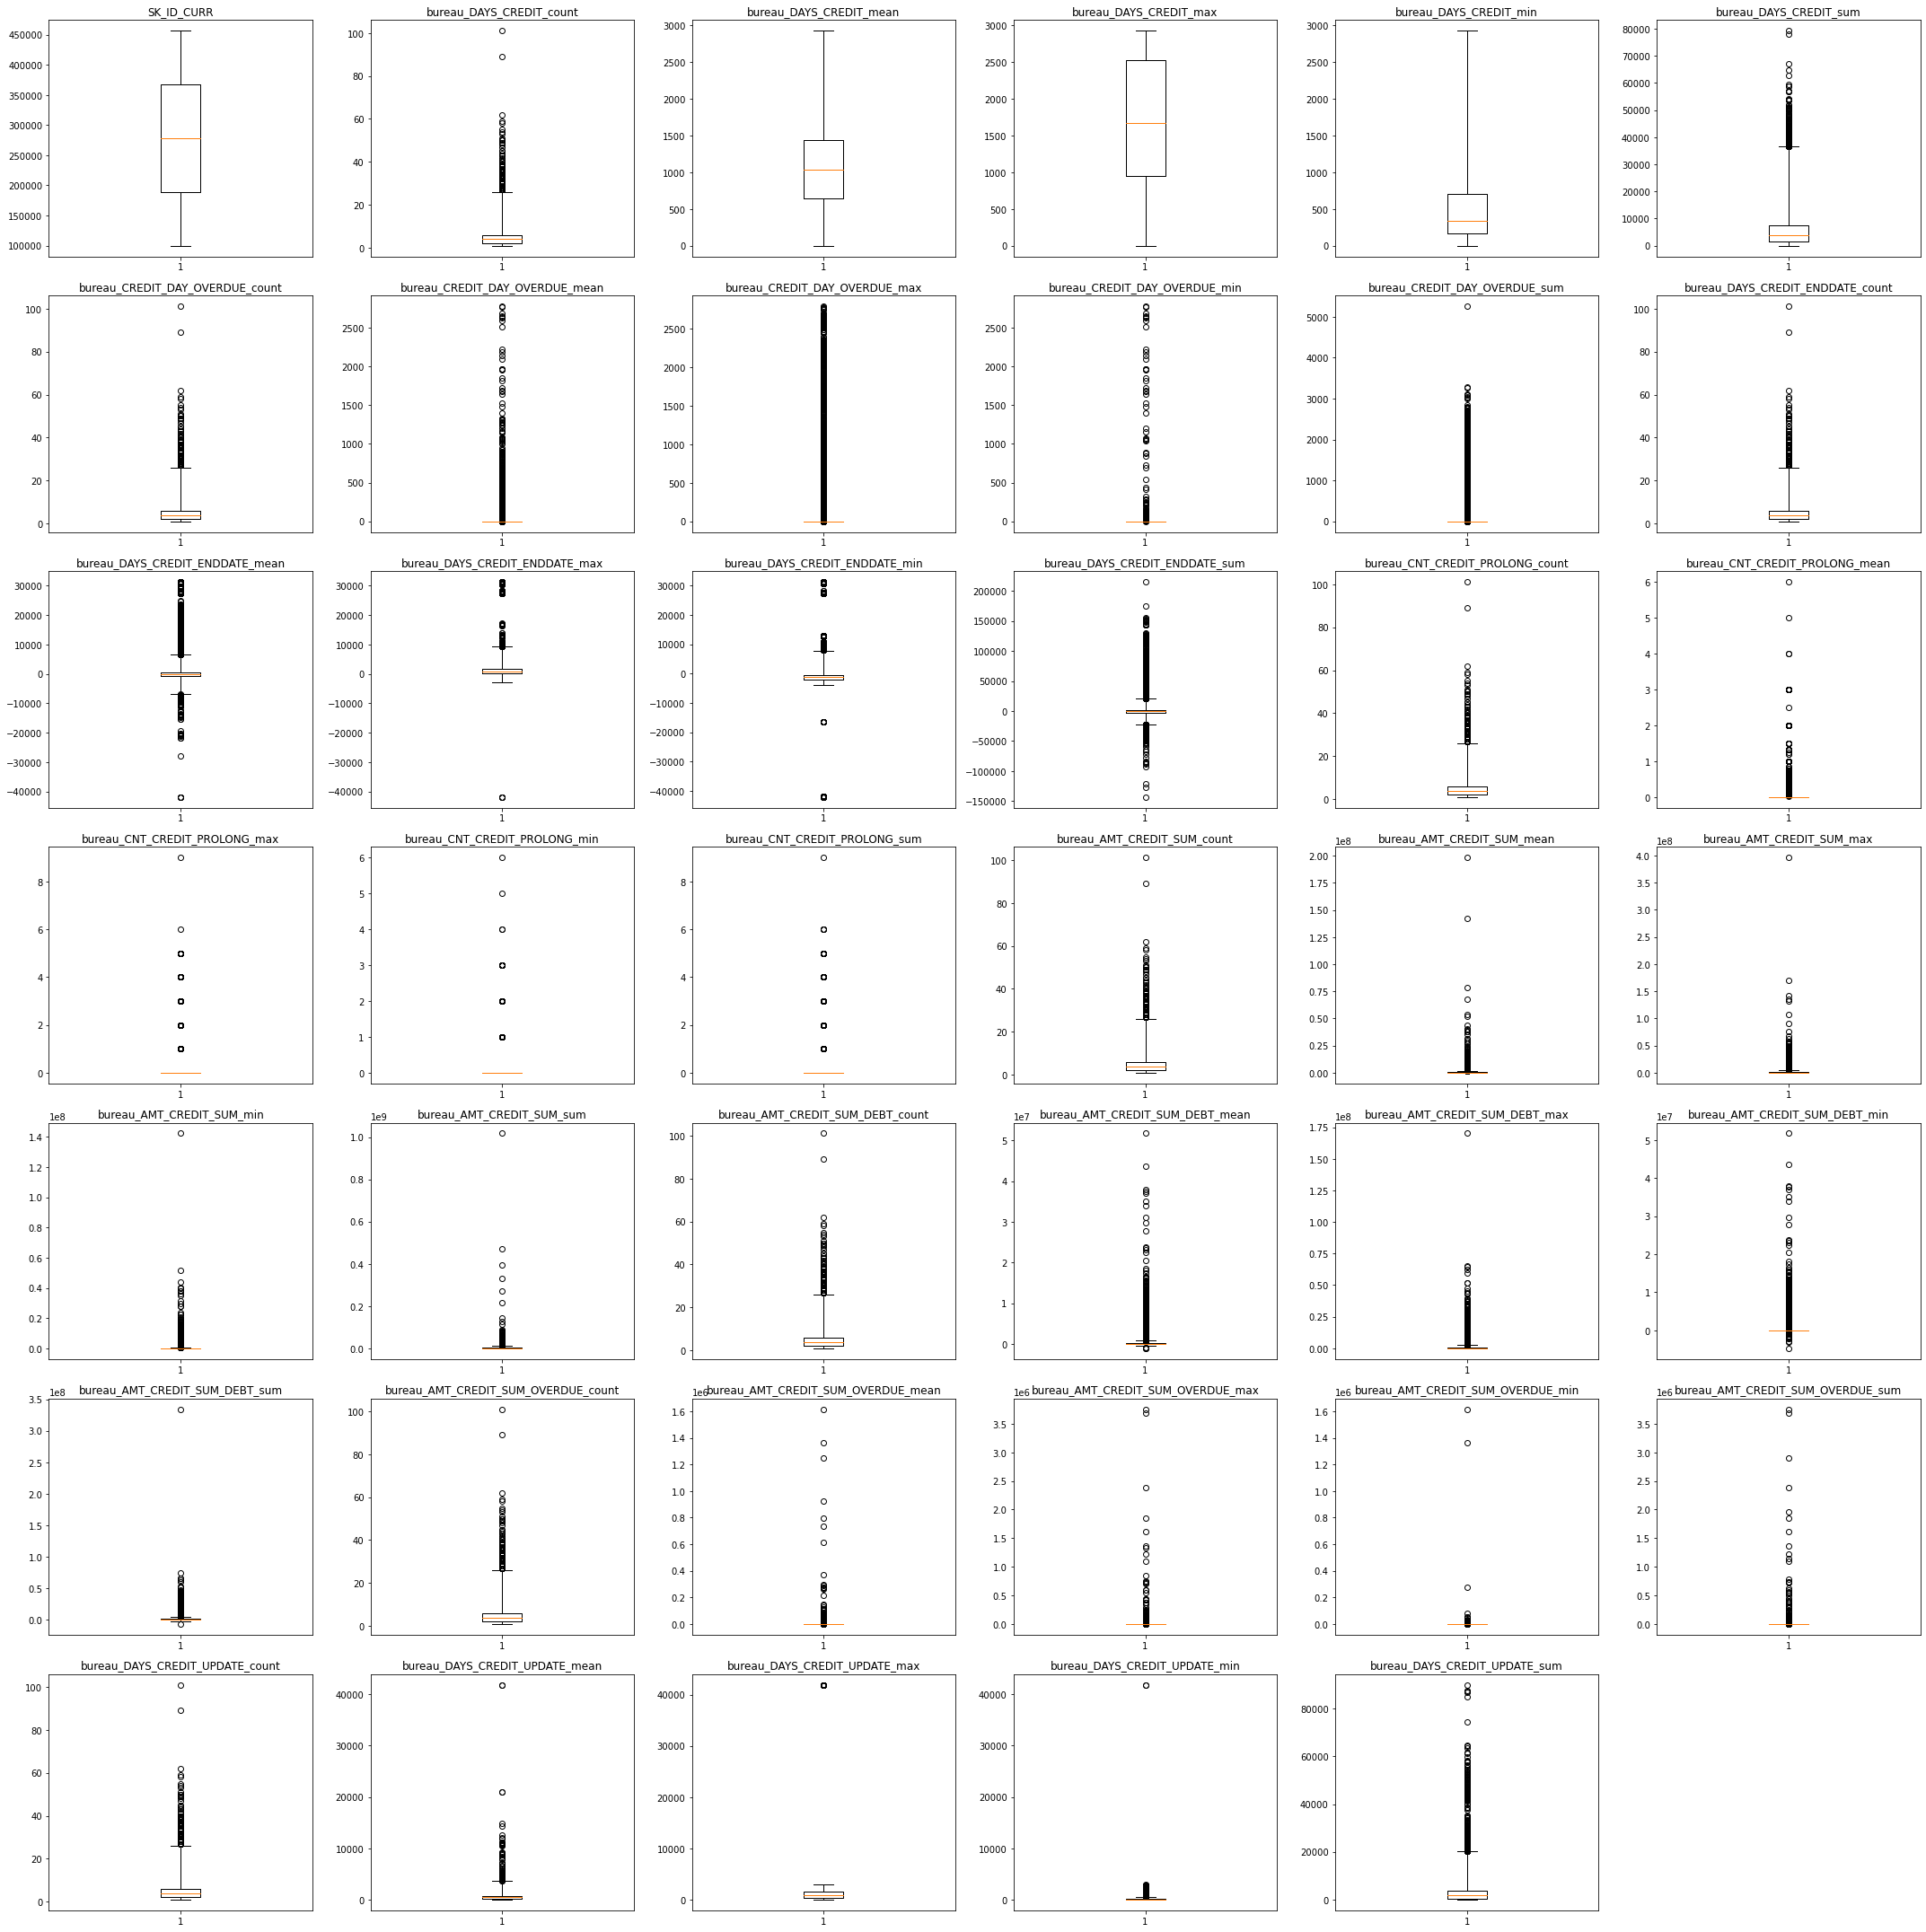

In [100]:
continuous_labels = bureau_stats.columns

i = 1
plt.figure(figsize=(30,30))
for var in continuous_labels:
    plt.subplot(7,6,i)
    plt.boxplot(bureau_stats[var],whis=5)
    plt.title(var)
    i+=1

plt.tight_layout()
plt.show()

Several outliers. We'll leave them untreated for now.

3. Get dummies of categorical variables, and then condense them into sums and means.

In [101]:
categorical = pd.get_dummies(bureau.select_dtypes(include=['object']))

categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']

categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
5,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
6,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
7,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,162297


In [102]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])

categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        1  0.333333                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        2  0.666667                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1      CREDIT_CURRENCY_currency 2       \
                                  sum mean                        sum mean   
SK_ID_CURR                                                                   
100001                              7  1.0                          0  0.0   
100002                              3  1.0                          0  0.0   
100003                              4  1.0                          0  0.0   
100004                              2  1.0                          0  0.0   
100005                              3  1.0                          0  0.0   

           CREDIT_CURRENCY_currency 3      CREDIT_CURRENCY_currency 4       \
                                  sum mean                        sum mean   
SK_ID_CURR                                                                   
100001                              0  0.0                          0  0.0   
100002                              0  0.0                          0  0.0   
100003                              0  0.0                          0  0.0   
100004                              0  0.0                          0  0.0   
100005                              0  0.0                          0  0.0   

           CREDIT_TYPE_Another type of loan      CREDIT_TYPE_Car loan       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Cash loan (non-earmarked)       \
                                             sum mean   
SK_ID_CURR                                              
100001                                         0  0.0   
100002                                         0  0.0   
100003                                         0  0.0   
100004                                         0  0.0   
100005                                         0  0.0   

           CREDIT_TYPE_Consumer credit           CREDIT_TYPE_Credit card  \
                                   sum      mean                     sum   
SK_ID_CURR                                                                 
100001                               7  1.000000                       0   
100002                               3  1.000000                       0   
100003                               2  0.500000                       2   
100004                               2  1.000000                       0   
100005   

Sum represents the count of the given category per applicant. Mean is represents a normalized count. Let's make individual columns per category per stat.

In [103]:
group_var = 'SK_ID_CURR'

columns = []

for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,CREDIT_CURRENCY_currency 2_count,CREDIT_CURRENCY_currency 2_count_norm,CREDIT_CURRENCY_currency 3_count,CREDIT_CURRENCY_currency 3_count_norm,CREDIT_CURRENCY_currency 4_count,CREDIT_CURRENCY_currency 4_count_norm,CREDIT_TYPE_Another type of loan_count,CREDIT_TYPE_Another type of loan_count_norm,CREDIT_TYPE_Car loan_count,CREDIT_TYPE_Car loan_count_norm,CREDIT_TYPE_Cash loan (non-earmarked)_count,CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,CREDIT_TYPE_Consumer credit_count,CREDIT_TYPE_Consumer credit_count_norm,CREDIT_TYPE_Credit card_count,CREDIT_TYPE_Credit card_count_norm,CREDIT_TYPE_Interbank credit_count,CREDIT_TYPE_Interbank credit_count_norm,CREDIT_TYPE_Loan for business development_count,CREDIT_TYPE_Loan for business development_count_norm,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,CREDIT_TYPE_Loan for the purchase of equipment_count,CREDIT_TYPE_Loan for the purchase of equipment_count_norm,CREDIT_TYPE_Loan for working capital replenishment_count,CREDIT_TYPE_Loan for working capital replenishment_count_norm,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,1,0.333333,0,0.0,2,0.666667,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,3,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [104]:
# Grouping column lines here for later referral

col_1 = previous_loan_counts.columns
col_2 = bureau_stats.columns
col_3 = categorical_grouped.columns

# Merging

In [105]:
df_merged = pd.merge(app, previous_loan_counts, on='SK_ID_CURR', how='left')
df_merged = pd.merge(df_merged, bureau_stats, on='SK_ID_CURR', how='left')
df_merged = pd.merge(df_merged, categorical_grouped, on = 'SK_ID_CURR', how='left')

print(df_merged.shape)
print(app.shape)

(283545, 241)
(283545, 154)


In [106]:
df_merged.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,...,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TYPE_train,PREVIOUS_LOAN_COUNTS,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,CREDIT_ACTIVE_A

In [107]:
missing_values_table(df_merged)

Your selected dataframe has 241 columns.
There are 89 columns that have missing values.


,Column,Missing Values,% of Total Values
9,DAYS_EMPLOYED,51440,18.1
1,TARGET,39269,13.8
239,CREDIT_TYPE_Unknown type of loan_count,8852,3.1
207,CREDIT_CURRENCY_currency 3_count,8852,3.1
215,CREDIT_TYPE_Cash loan (non-earmarked)_count,8852,3.1
214,CREDIT_TYPE_Car loan_count_norm,8852,3.1
213,CREDIT_TYPE_Car loan_count,8852,3.1
212,CREDIT_TYPE_Another type of loan_count_norm,8852,3.1
211,CREDIT_TYPE_Another type of loan_count,8852,3.1
210,CREDIT_CURRENCY_currency 4_count_norm,8852,3.1


I will drop the rows for columns with 3.1% missing values. We saw earlier that days_employed has a weak correlation with our target. Even though we could we could improve this correlation by feature engineering, keeping the variable would imply imputing 18.1% of its values. I am not satisfied by the categorical variables available for me to make imputation 'higher resolution' through groupby functions, and simply imputation would increase the risk of distorted data, so I will drop that column.

In [108]:
# missing_columns = list(missing_values.index[(missing_values['% of Total Values'] == 4.5) | (missing_values['% of Total Values'] == 18.1)])

# Filtering for columns where we will only drop rows

missing_values = missing_values_table(df_merged)

missing_columns = list(missing_values[missing_values['% of Total Values'] == 3.1]['Column'])

len(missing_columns)

Your selected dataframe has 241 columns.
There are 89 columns that have missing values.


87

In [109]:
# Dropping the rows

df_merged.dropna(subset=missing_columns, inplace=True)

# Dropping the days_employed column

df_merged.drop(columns=['DAYS_EMPLOYED'], inplace = True)

In [110]:
new_corr = df_merged.corr()['TARGET'].sort_values()

print(new_corr.head(10))

print('\n')

print(new_corr.tail(10))

EXT_SOURCE_3                           -0.179886
EXT_SOURCE_2                           -0.154065
bureau_DAYS_CREDIT_mean                -0.084626
DAYS_BIRTH                             -0.078602
bureau_DAYS_CREDIT_max                 -0.073008
CREDIT_ACTIVE_Closed_count_norm        -0.070636
bureau_DAYS_CREDIT_UPDATE_mean         -0.060642
NAME_EDUCATION_TYPE_Higher education   -0.053485
DAYS_LAST_PHONE_CHANGE                 -0.051471
bureau_DAYS_CREDIT_min                 -0.049508
Name: TARGET, dtype: float64


REGION_RATING_CLIENT               0.054088
NAME_INCOME_TYPE_Working           0.055024
bureau_DAYS_CREDIT_ENDDATE_sum     0.055081
REGION_RATING_CLIENT_W_CITY        0.056202
CREDIT_ACTIVE_Active_count         0.056435
CREDIT_ACTIVE_Active_count_norm    0.069347
TARGET                             1.000000
FLAG_MOBIL                              NaN
FLAG_DOCUMENT_2                         NaN
TYPE_train                              NaN
Name: TARGET, dtype: float64


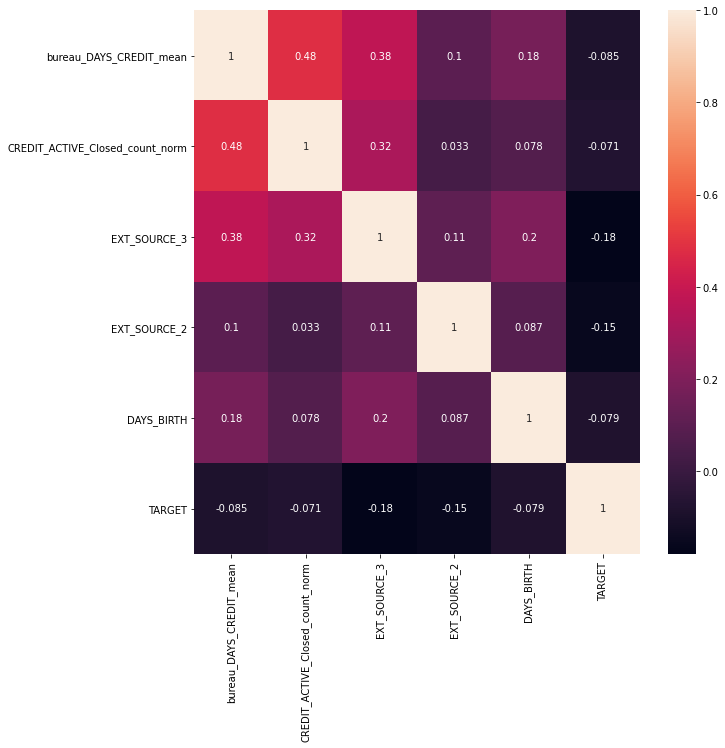

In [111]:
mvp_group = ['bureau_DAYS_CREDIT_mean',
              'CREDIT_ACTIVE_Closed_count_norm',
              'EXT_SOURCE_3',
              'EXT_SOURCE_2',
              'DAYS_BIRTH',
             'TARGET']

mvp_corr = df_merged[mvp_group].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(mvp_corr, annot=True)
plt.show()

Both of our bureau metrics are fairly collinear with EXT_SOURCE_3, and even more so between each other. This is a good opportunity for PCA trials.

## Feature Engineering

### Polynomial Transformations

We will start feature engineering on the dataset with polynomial transformations.

In [112]:
# Let's free some up by deleting old objects before we proceed

import gc
gc.enable()
gc.collect()

103324

In [113]:
# Polynomial transformations

poly_features = df_merged[['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'bureau_DAYS_CREDIT_mean', 'TARGET']]

# Filtering and dropping target
poly_target = df_merged['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

from sklearn.preprocessing import PolynomialFeatures

In [114]:
poly_features.shape

(274693, 4)

In [115]:
from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (274693, 35)


A lot of new features have been created. Let's see which ones.

In [116]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'bureau_DAYS_CREDIT_mean'])[:15]

['1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'bureau_DAYS_CREDIT_mean',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_2 bureau_DAYS_CREDIT_mean',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_3 bureau_DAYS_CREDIT_mean',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH bureau_DAYS_CREDIT_mean',
 'bureau_DAYS_CREDIT_mean^2']

In [117]:
# Creating dataframe of the new columns to test correlations

poly_features = pd.DataFrame(poly_features, columns = poly_transformer.get_feature_names(input_features= ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'bureau_DAYS_CREDIT_mean']))

# Add in target
poly_features['TARGET'] = poly_target

# Find correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail())

EXT_SOURCE_2 DAYS_BIRTH^2                         -0.003711
DAYS_BIRTH^3                                      -0.003471
DAYS_BIRTH^2                                      -0.003331
EXT_SOURCE_2 DAYS_BIRTH                           -0.003216
DAYS_BIRTH                                        -0.003088
EXT_SOURCE_2^2 DAYS_BIRTH                         -0.002151
DAYS_BIRTH^2 bureau_DAYS_CREDIT_mean              -0.002134
EXT_SOURCE_2                                      -0.001932
EXT_SOURCE_2 DAYS_BIRTH bureau_DAYS_CREDIT_mean   -0.001844
EXT_SOURCE_3 DAYS_BIRTH^2                         -0.001430
Name: TARGET, dtype: float64
EXT_SOURCE_3 bureau_DAYS_CREDIT_mean    0.001206
EXT_SOURCE_3^2                          0.001265
EXT_SOURCE_3                            0.002066
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


These correlations are worse than our originals. Not including them.

### Creating Financial Variables

In [118]:
df_merged['CREDIT_INCOME_PERCENT'] = df_merged['AMT_CREDIT'] / df_merged['AMT_INCOME_TOTAL']

print(pearsonr(df_merged[df_merged['TYPE_train'] == 1]['CREDIT_INCOME_PERCENT'], df_merged[df_merged['TYPE_train'] == 1]['TARGET']))

print(pearsonr(df_merged[df_merged['TYPE_train'] == 1]['AMT_CREDIT'], df_merged[df_merged['TYPE_train'] == 1]['TARGET']))

print(pearsonr(df_merged[df_merged['TYPE_train'] == 1]['AMT_INCOME_TOTAL'], df_merged[df_merged['TYPE_train'] == 1]['TARGET']))

(-0.01050852332212662, 3.1885633031807777e-07)
(-0.02864021238400219, 3.897810138218644e-44)
(-0.0004893659108760671, 0.8118430959303568)


This new variable has a stronger correlation to our target than AMT_INCOME_TOTAL, but worse than AMT_CREDIT alone. We won't take it. AMT_INCOME_TOTAL is not statistically significant. We will keep it for PCA.

In [119]:
df_merged['ANNUITY_INCOME_PERCENT'] = df_merged['AMT_ANNUITY'] / df_merged['AMT_INCOME_TOTAL']

print(pearsonr(df_merged[df_merged['TYPE_train'] == 1]['ANNUITY_INCOME_PERCENT'], df_merged[df_merged['TYPE_train'] == 1]['TARGET']))

print(pearsonr(df_merged[df_merged['TYPE_train'] == 1]['AMT_ANNUITY'], df_merged[df_merged['TYPE_train'] == 1]['TARGET']))

(0.009614525156260505, 2.91054662828849e-06)
(-0.012463636276686452, 1.3352826658189824e-09)


This new variable has a mildly stronger better correlation than its both component parts. We'll keep it.

In [120]:
overdue_cols = [col for col in df_merged.columns if 'AMT_CREDIT_SUM' in col]

print(overdue_cols)

['bureau_AMT_CREDIT_SUM_count', 'bureau_AMT_CREDIT_SUM_mean', 'bureau_AMT_CREDIT_SUM_max', 'bureau_AMT_CREDIT_SUM_min', 'bureau_AMT_CREDIT_SUM_sum', 'bureau_AMT_CREDIT_SUM_DEBT_count', 'bureau_AMT_CREDIT_SUM_DEBT_mean', 'bureau_AMT_CREDIT_SUM_DEBT_max', 'bureau_AMT_CREDIT_SUM_DEBT_min', 'bureau_AMT_CREDIT_SUM_DEBT_sum', 'bureau_AMT_CREDIT_SUM_OVERDUE_count', 'bureau_AMT_CREDIT_SUM_OVERDUE_mean', 'bureau_AMT_CREDIT_SUM_OVERDUE_max', 'bureau_AMT_CREDIT_SUM_OVERDUE_min', 'bureau_AMT_CREDIT_SUM_OVERDUE_sum']


In [121]:
df_merged['CREDIT_HEALTH'] = df_merged['bureau_AMT_CREDIT_SUM_OVERDUE_sum'] * df_merged['bureau_AMT_CREDIT_SUM_sum'] * df_merged['bureau_AMT_CREDIT_SUM_OVERDUE_count']

print(pearsonr(df_merged[df_merged['TYPE_train'] == 1]['CREDIT_HEALTH'], df_merged[df_merged['TYPE_train'] == 1]['TARGET']))

print(pearsonr(df_merged[df_merged['TYPE_train'] == 1]['bureau_AMT_CREDIT_SUM_OVERDUE_sum'], df_merged[df_merged['TYPE_train'] == 1]['TARGET']))

print(pearsonr(df_merged[df_merged['TYPE_train'] == 1]['bureau_AMT_CREDIT_SUM_sum'], df_merged[df_merged['TYPE_train'] == 1]['TARGET']))

(0.007882429316203076, 0.00012586202202652903)
(0.012029261715892074, 4.8636713619215305e-09)
(-0.013484422319122022, 5.391221036522617e-11)


Slightly better than one but worse than the other. We won't keep it.

In [122]:
# Dropping the non-useful features.

df_merged.drop(columns=['CREDIT_HEALTH', 'CREDIT_INCOME_PERCENT'], inplace = True)

In [123]:
df_merged.shape

(274693, 241)

### PCA

In [124]:
#temporaly display all columns

with pd.option_context('display.max_seq_items', None):
    print (df_merged.select_dtypes('float64').columns)


Index(['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREVIOUS_LOAN_COUNTS',
       'bureau_DAYS_CREDIT_count', 'bureau_DAYS_CREDIT_mean',
       'bureau_DAYS_CREDIT_max', 'bureau_DAYS_CREDIT_min',
       'bureau_DAYS_CREDIT_sum', 'bureau_CREDIT_DAY_OVERDUE_count',
       'bureau_CREDIT_DAY_OVERDUE_mean', 'bureau_CREDIT_DAY_OVERDUE_max',
       'bureau_CREDIT_DAY_OVERDUE_min', 'bureau_CREDIT_DAY_OVERDUE_sum',
       'bureau_DAYS_CREDIT_ENDDATE_count', 'bureau_DAYS_CREDIT_ENDDATE_mean',
    

In [125]:
currency = [col for col in df_merged.columns if 'CREDIT_CURRENCY_currency' in col]

currency += ['TARGET']

print(currency)

['CREDIT_CURRENCY_currency 1_count', 'CREDIT_CURRENCY_currency 1_count_norm', 'CREDIT_CURRENCY_currency 2_count', 'CREDIT_CURRENCY_currency 2_count_norm', 'CREDIT_CURRENCY_currency 3_count', 'CREDIT_CURRENCY_currency 3_count_norm', 'CREDIT_CURRENCY_currency 4_count', 'CREDIT_CURRENCY_currency 4_count_norm', 'TARGET']


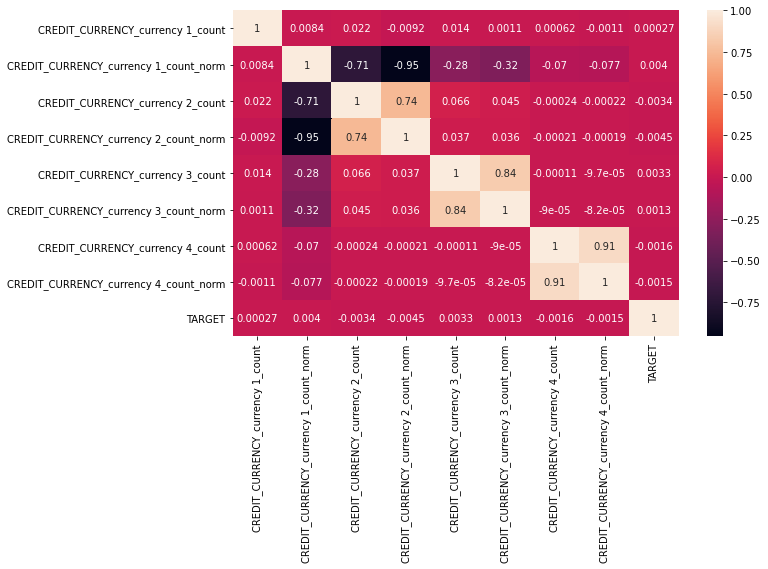

In [126]:
currency_corrs = df_merged[currency].corr()


plt.figure(figsize=(10, 6))
sns.heatmap(currency_corrs, annot=True)
plt.show()

# All variables have low correlation with the target. I will do PCA with all these variables 
# and just the collinear ones (-0.29 and up), and see what variable has the highest correlation to target.

In [127]:
currency_co = ['CREDIT_CURRENCY_currency 1_count_norm', 'CREDIT_CURRENCY_currency 2_count_norm',
               'CREDIT_CURRENCY_currency 3_count_norm', 'CREDIT_CURRENCY_currency 3_count',
              'CREDIT_CURRENCY_currency 4_count', 'CREDIT_CURRENCY_currency 4_count_norm']

In [128]:
currency_target = ['TARGET']

currency.remove('TARGET')

In [129]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Highly collinear currency variables

X_currency_co = df_merged[currency_co]

X_currency_co = StandardScaler().fit_transform(X_currency_co)

# SS finds standard-score/z-score (aka subtracts mean and makes sigma 1) 
# fit selects mean and standard deviation, 

sklearn_pca = PCA(n_components=1)
df_merged['pca_currency_collinear'] = sklearn_pca.fit_transform(X_currency_co)

print(
'The percentage of total variance in the dataset explained by each',
'component from Sklearn PCA.\n',
sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.37687767]


In [130]:
# Not highly collinear variables

X_currency_all = df_merged[currency]

X_currency_all = StandardScaler().fit_transform(X_currency_all)

# SS finds standard-score/z-score (aka subtracts mean and makes sigma 1) 
# fit selects mean and standard deviation, 

sklearn_pca = PCA(n_components=1)
df_merged['pca_currency_all'] = sklearn_pca.fit_transform(X_currency_all)

print(
'The percentage of total variance in the dataset explained by each',
'component from Sklearn PCA.\n',
sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.34211973]


In [131]:
# Not highly collinear variables

AMT = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY','AMT_GOODS_PRICE']

AMT_pca = df_merged[AMT]

AMT_pca = StandardScaler().fit_transform(AMT_pca)

# SS finds standard-score/z-score (aka subtracts mean and makes sigma 1) 
# fit selects mean and standard deviation, 

sklearn_pca = PCA(n_components=1)
df_merged['AMT_pca'] = sklearn_pca.fit_transform(AMT_pca)

print(
'The percentage of total variance in the dataset explained by each',
'component from Sklearn PCA.\n',
sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.6827627]


In [132]:
varied = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'PREVIOUS_LOAN_COUNTS']

varied_pca = df_merged[varied]

varied_pca = StandardScaler().fit_transform(varied_pca)

# SS finds standard-score/z-score (aka subtracts mean and makes sigma 1) 
# fit selects mean and standard deviation, 

sklearn_pca = PCA(n_components=1)
df_merged['varied_pca'] = sklearn_pca.fit_transform(varied_pca)

print(
'The percentage of total variance in the dataset explained by each',
'component from Sklearn PCA.\n',
sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.2751828]


In [133]:
currency += ['pca_currency_collinear', 'pca_currency_all', 'AMT_pca', 'varied_pca']
currency += currency_target

final_pca_list = currency

final_pca_list

['CREDIT_CURRENCY_currency 1_count',
 'CREDIT_CURRENCY_currency 1_count_norm',
 'CREDIT_CURRENCY_currency 2_count',
 'CREDIT_CURRENCY_currency 2_count_norm',
 'CREDIT_CURRENCY_currency 3_count',
 'CREDIT_CURRENCY_currency 3_count_norm',
 'CREDIT_CURRENCY_currency 4_count',
 'CREDIT_CURRENCY_currency 4_count_norm',
 'pca_currency_collinear',
 'pca_currency_all',
 'AMT_pca',
 'varied_pca',
 'TARGET']

In [134]:
final_pca_list += AMT

In [135]:
final_pca_list += ['DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'PREVIOUS_LOAN_COUNTS']

In [136]:
df_merged[currency].corr()['TARGET'].sort_values()

DAYS_BIRTH                              -0.078602
AMT_GOODS_PRICE                         -0.037707
AMT_CREDIT                              -0.028640
AMT_pca                                 -0.027671
AMT_ANNUITY                             -0.012464
varied_pca                              -0.011718
CREDIT_CURRENCY_currency 2_count_norm   -0.004471
CREDIT_CURRENCY_currency 2_count        -0.003381
pca_currency_all                        -0.003307
pca_currency_collinear                  -0.001868
CREDIT_CURRENCY_currency 4_count        -0.001583
CREDIT_CURRENCY_currency 4_count_norm   -0.001468
AMT_INCOME_TOTAL                        -0.000489
PREVIOUS_LOAN_COUNTS                     0.000230
CREDIT_CURRENCY_currency 1_count         0.000271
CREDIT_CURRENCY_currency 3_count_norm    0.001267
CREDIT_CURRENCY_currency 3_count         0.003301
CREDIT_CURRENCY_currency 1_count_norm    0.003979
REGION_RATING_CLIENT_W_CITY              0.056202
TARGET                                   1.000000


Our AMT pca has better correlations with the target than amt_annuity and amt_income_total. We'll drop those two, along with the other pcas we did, which were not so useful.

In [137]:
df_merged.drop(columns=['varied_pca', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'pca_currency_all', 'pca_currency_collinear'], inplace=True)

In [138]:
df_merged.shape

(274693, 240)

# Feature Selection

### Identifying highly correlated variables

In [139]:
# Threshold for removing highly correlated variables

threshold = 0.8

In [140]:
# Holding out 

# Absolute value correlation matrix

df_copy = df_merged.copy()

corr_matrix = df_copy.corr().abs()

# corr_matrix.head()

In [141]:
# Filtering for the upper triangle of correlations

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

upper.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TYPE_train,PREVIOUS_LOAN_COUNTS,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,CREDIT_ACTIVE_Active_co

In [142]:
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

print('There are {} columns to remove.'.format(len(to_drop)))

print(to_drop)

There are 46 columns to remove.
['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'ORGANIZATION_TYPE_XNA', 'bureau_DAYS_CREDIT_count', 'bureau_DAYS_CREDIT_max', 'bureau_DAYS_CREDIT_sum', 'bureau_CREDIT_DAY_OVERDUE_count', 'bureau_CREDIT_DAY_OVERDUE_sum', 'bureau_DAYS_CREDIT_ENDDATE_count', 'bureau_DAYS_CREDIT_ENDDATE_sum', 'bureau_CNT_CREDIT_PROLONG_count', 'bureau_CNT_CREDIT_PROLONG_sum', 'bureau_AMT_CREDIT_SUM_count', 'bureau_AMT_CREDIT_SUM_max', 'bureau_AMT_CREDIT_SUM_sum', 'bureau_AMT_CREDIT_SUM_DEBT_count', 'bureau_AMT_CREDIT_SUM_DEBT_sum', 'bureau_AMT_CREDIT_SUM_OVERDUE_count', 'bureau_AMT_CREDIT_SUM_OVERDUE_max', 'bureau_AMT_CREDIT_SUM_OVERDUE_sum', 'bureau_DAYS_CREDIT_UPDATE_count', 'bureau_DAYS_CREDIT_UPDATE_sum', 'CREDIT_ACTIVE_Ba

In [143]:
# Drop columns

df_merged.drop(columns = to_drop, inplace=True)

In [144]:
df_merged.shape

(274693, 194)

Let's get ready to model.

# Modelling

### Prepping Tools

In [145]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectFromModel, RFE

from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, roc_curve, precision_recall_curve, roc_auc_score, auc, recall_score

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize

import timeit
from datetime import datetime



import itertools
from itertools import cycle

from sklearn.model_selection import StratifiedKFold

from numpy import interp

In [146]:
# Timer Function

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [147]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [148]:
# Value counts for train and test sets

df_merged['TYPE_train'].value_counts()

1    236630
0     38063
Name: TYPE_train, dtype: int64

In [149]:
# Filtering our dataset for the original train set, since the test set does not have target scores to test against.

df_merged = df_merged[df_merged['TYPE_train'] == 1]

In [150]:
# Confirming the filter has been successful

df_merged['TYPE_train'].value_counts()

1    236630
Name: TYPE_train, dtype: int64

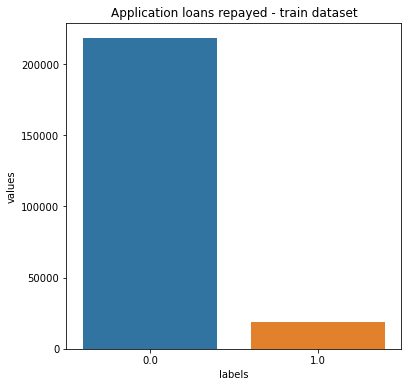

In [151]:
# Data is actually more balanced now

temp = df_merged['TARGET'].value_counts()
target_graph = pd.DataFrame({'labels':temp.index,
                   'values':temp.values    
})

plt.figure(figsize=(6,6))

plt.title('Application loans repayed - train dataset')

sns.set_color_codes('pastel')
sns.barplot(x=target_graph['labels'], y=target_graph['values'])
locs, labels = plt.xticks()

plt.show()

# Random Forest

### SMOTE Balancing

In [152]:
# Checking for null target values

df_merged['TARGET'].isnull().sum()

0

In [153]:
# Assigning X and y variables

X = df_merged.drop(columns = ['TARGET', 'TYPE_train'])
y = df_merged['TARGET']

In [154]:
# Balancing the data

sm = SMOTE(random_state = 42, sampling_strategy = 'not majority')
X, y = sm.fit_resample(X, y)

In [155]:
# Setting up hyperparameters

params={
    "max_depth"        : [2, 3, 4],
    "min_samples_split" : [2, 10, 200, 800, 1000],
    "max_leaf_nodes"     : [10, 20, 25, 30],
    "min_samples_leaf" : [1, 10, 100, 250, 500, 1000],
    'n_estimators'        : [20, 30, 40, 100],
    'max_samples': [0.2, 0.6, 1.0]
}

In [156]:
# Setting up RandomizedSearchCV and fitting our model

clf = RandomForestClassifier()

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=10, scoring='recall', iid=False, n_jobs=-1, random_state=42, cv=5, verbose=3)

start_time = timer(None)

random_search.fit(X, y)

timer(start_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.3s finished



 Time taken: 0 hours 1 minutes and 9.28 seconds.


In [157]:
random_search.best_params_, random_search.best_score_

({'n_estimators': 100,
  'min_samples_split': 1000,
  'min_samples_leaf': 10,
  'max_samples': 0.2,
  'max_leaf_nodes': 10,
  'max_depth': 4},
 0.8695638223653746)

Excellent performance to begin! It also seems like some of the best parameter values were either on the extremes of our list, had no numerically close values to choose from, or both. This is a good opportunity for hyperparameter tuning.

In [158]:
params={
    "max_depth"        : [3, 4, 5, 6],
    "min_samples_split" : [800, 1000, 1200, 1500],
    "max_leaf_nodes"     : [5, 10, 15],
    "min_samples_leaf" : [8, 10, 15, 20],
    'n_estimators'        : [80, 100, 150, 200, 250],
    'max_samples': [0.2, 0.6, 1.0]
}

In [159]:
clf = RandomForestClassifier()

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=10, scoring='recall', iid=False, n_jobs=-1, random_state=42, cv=5, verbose=3)

start_time = timer(None)

random_search.fit(X, y)

timer(start_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished



 Time taken: 0 hours 4 minutes and 12.89 seconds.


In [160]:
random_search.best_params_, random_search.best_score_

({'n_estimators': 200,
  'min_samples_split': 1500,
  'min_samples_leaf': 10,
  'max_samples': 0.2,
  'max_leaf_nodes': 15,
  'max_depth': 4},
 0.8774711361197601)

In [161]:
# Taking a look at our best estimator

random_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=15, max_samples=0.2,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=1500,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [162]:
# Fitting our data with our best estimator

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=15, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=1200,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)

clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=15, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=1200,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

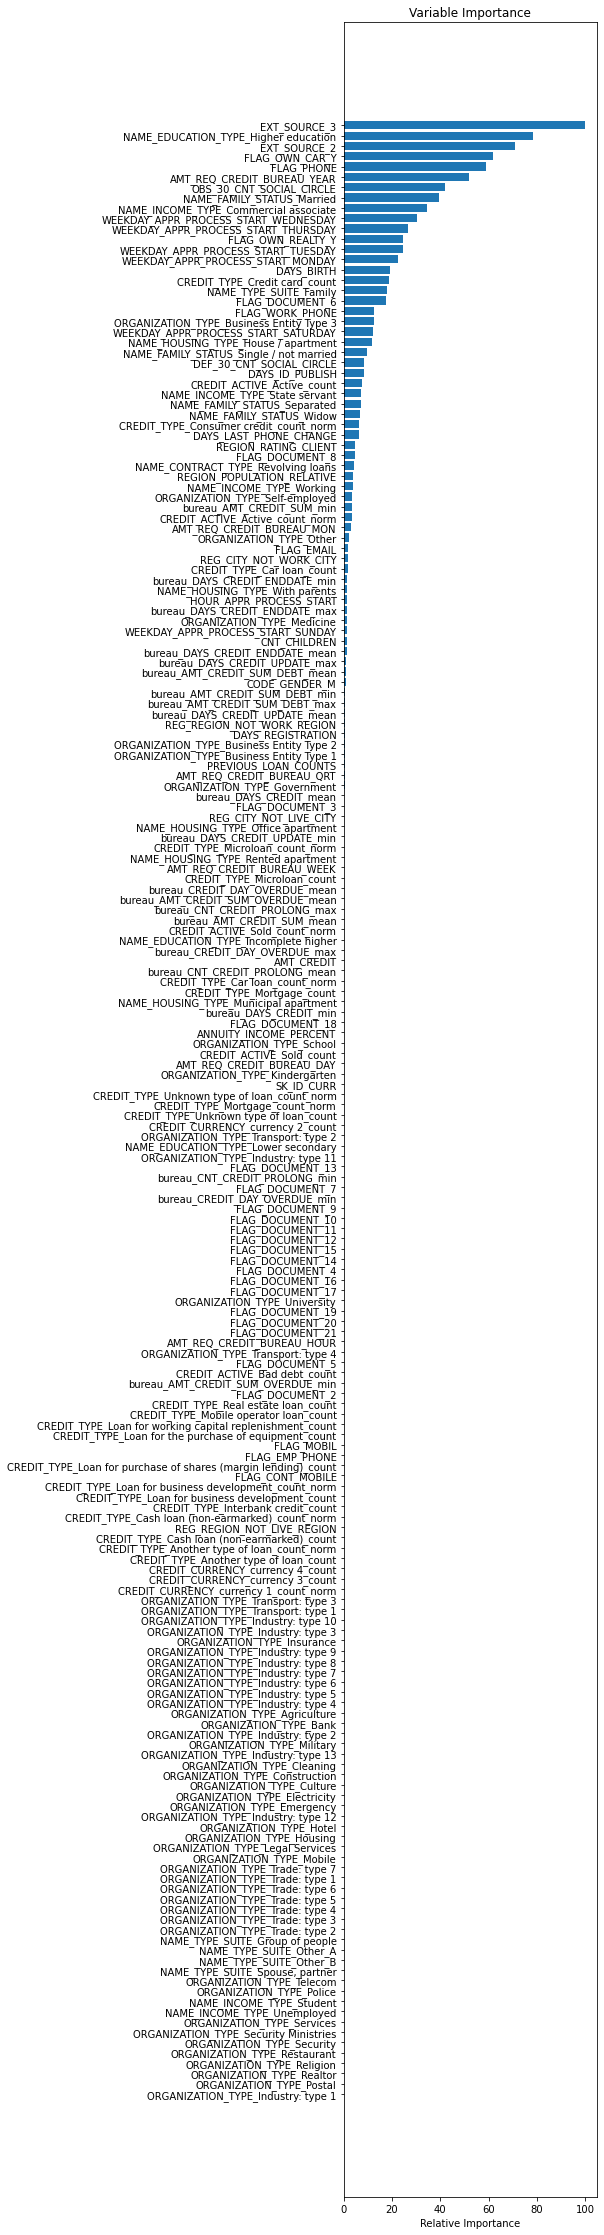

In [163]:
# Plotting feature importances

feature_importance = clf.feature_importances_

plt.figure(figsize= (10,40))
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

A large amount of features here have 0 or near-zero importance levels. After we identify our best models, we will average feature importances out and drop those that score the lowest, reducing dimensionality and noise.

In [164]:
# Visualizing numerical values for importances

rfm_smoted_importances = pd.DataFrame(clf.feature_importances_, X.columns)
rfm_smoted_importances = rfm_smoted_importances.sort_values(by=0, ascending=False)

In [165]:
# Renaming the columns to something more workable / identifiable

rfm_smoted_importances.reset_index(inplace=True)

rfm_smoted_importances.rename(columns = {'index': 'feature', 0: 'importance'}, inplace=True)

In [166]:
rfm_smoted_importances.head(10) #showing the 15 most important features

,feature,importance
0,EXT_SOURCE_3,0.108365
1,NAME_EDUCATION_TYPE_Higher education,0.084780
2,EXT_SOURCE_2,0.076864
3,FLAG_OWN_CAR_Y,0.067115
4,FLAG_PHONE,0.063952
5,AMT_REQ_CREDIT_BUREAU_YEAR,0.056161
6,OBS_30_CNT_SOCIAL_CIRCLE,0.045647
7,NAME_FAMILY_STATUS_Married,0.042875
8,NAME_INCOME_TYPE_Commercial associate,0.037396
9,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,0.032937


### No SMOTE Balancing

In [167]:
# Repeating the above process with without balancing the dataset

X = df_merged.drop(columns = ['TARGET', 'TYPE_train'])
y = df_merged['TARGET']

In [168]:
params={
    "max_depth"        : [3, 4, 5, 6],
    "min_samples_split" : [800, 1000, 1200, 1500],
    "max_leaf_nodes"     : [5, 10, 15],
    "min_samples_leaf" : [8, 10, 15, 20],
    'n_estimators'        : [80, 100, 150, 200, 250],
    'max_samples': [0.2, 0.6, 1.0]
}

In [169]:
clf = RandomForestClassifier()

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=10, scoring='recall', iid=False, n_jobs=-1, random_state=42, cv=5, verbose=3)

start_time = timer(None)

random_search.fit(X, y)

timer(start_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished



 Time taken: 0 hours 1 minutes and 42.1 seconds.


In [170]:
random_search.best_params_, random_search.best_score_

({'n_estimators': 80,
  'min_samples_split': 800,
  'min_samples_leaf': 20,
  'max_samples': 0.6,
  'max_leaf_nodes': 5,
  'max_depth': 4},
 0.0)

Our recall score was 0. It seems like SMOTE makes a huge difference.

In [171]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=5, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=800,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [172]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=5, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=800,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)

clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=5, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=800,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

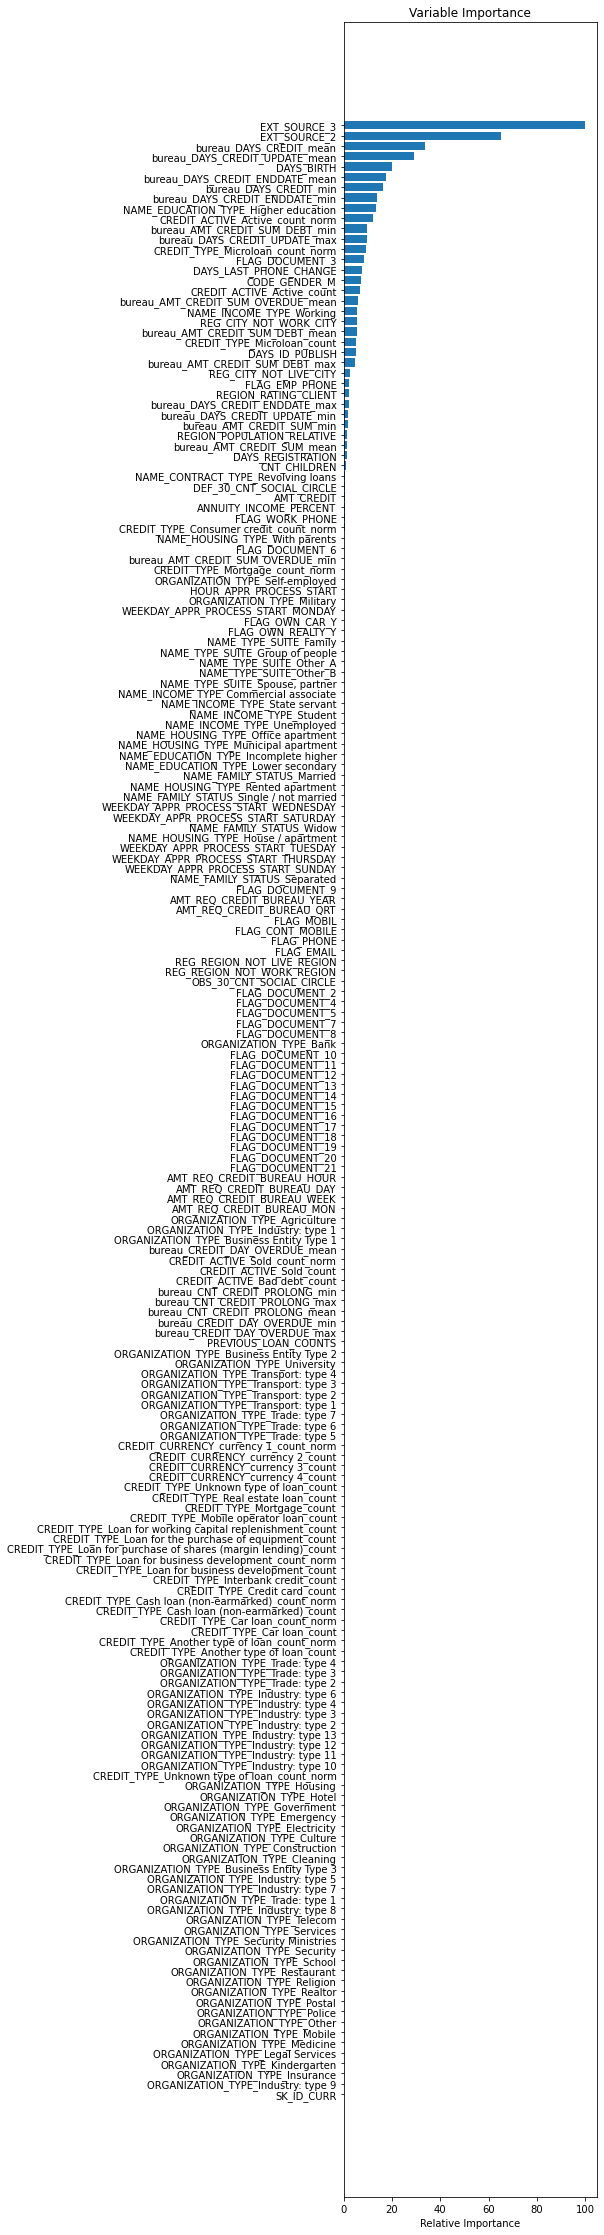

In [173]:
feature_importance = clf.feature_importances_

plt.figure(figsize= (10,40))
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# If one categorical variable's dummy variable is important and the others are not, you keep all of them.

In [174]:
rfm_imbalanced_importances = pd.DataFrame(clf.feature_importances_, X.columns)
rfm_imbalanced_importances = rfm_imbalanced_importances.sort_values(by=0, ascending=False)
rfm_imbalanced_importances.head(10) #show 15 most important features

,0
EXT_SOURCE_3,0.226935
EXT_SOURCE_2,0.147659
bureau_DAYS_CREDIT_mean,0.076299
bureau_DAYS_CREDIT_UPDATE_mean,0.066039
DAYS_BIRTH,0.045789
bureau_DAYS_CREDIT_ENDDATE_mean,0.039607
bureau_DAYS_CREDIT_min,0.037228
bureau_DAYS_CREDIT_ENDDATE_min,0.030984
NAME_EDUCATION_TYPE_Higher education,0.030362
CREDIT_ACTIVE_Active_count_norm,0.027740


# Logistic Regression

### Smote Balancing

In [175]:
# Assigning variables

X = df_merged.drop(columns = ['TARGET', 'TYPE_train'])
y = df_merged['TARGET']

In [176]:
# Balance data

sm = SMOTE(random_state = 42, sampling_strategy = 'not majority')

X, y = sm.fit_resample(X, y)

In [177]:
# Setting up hyperparameters for GridSearchCV

params={
    "C" : [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter" : [100, 200, 300]
}

In [178]:
# Running GridSearch and fitting the model

clf = LogisticRegression(solver = 'lbfgs')

grid_search = GridSearchCV(clf, param_grid=params, scoring='recall', n_jobs=-1, cv=3, verbose=3)

start_time = timer(None)

grid_search.fit(X, y)

timer(start_time)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  5.3min finished



 Time taken: 0 hours 5 minutes and 56.81 seconds.


In [179]:
grid_search.best_params_, grid_search.best_score_

({'C': 0.01, 'max_iter': 300}, 0.5440864355423537)

The score is a decent start, but not quite as good as our SMOTE-balanced Random Forest. Logistic regression is judged by coefficient to determine the best features ('feature importances' are something that only tree-based models have). Since our score is not great and is only marginally improvable through more tuning, I will not consider this model's feature scores to average out feature importances, meaning I won't develop it further.

### No Smote Balancing

In [180]:
# Assigning variables

X = df_merged.drop(columns = ['TARGET', 'TYPE_train'])
y = df_merged['TARGET']

In [181]:
# Setting up hyperparameters for GridSearchCV

params={
    "C" : [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter" : [100, 200, 300]
}

In [182]:
# Create model

clf = LogisticRegression(solver = 'lbfgs')

grid_search = GridSearchCV(clf, param_grid=params, scoring='recall', n_jobs=-1, cv=3, verbose=3)

start_time = timer(None)

grid_search.fit(X, y)

timer(start_time)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.0min finished



 Time taken: 0 hours 3 minutes and 11.27 seconds.


In [183]:
grid_search.best_params_, grid_search.best_score_

({'C': 0.01, 'max_iter': 200}, 0.000108242680088759)

Near-zero score once again. It seems like SMOTE-balancing is crucial to reduce type II errors.

# XGBoost

### Smote Balancing

In [184]:
# Assigning Variables

X = df_merged.drop(columns = ['TARGET', 'TYPE_train'])
y = df_merged['TARGET']

In [185]:
# Balancing the data

sm = SMOTE(random_state = 42, sampling_strategy = 'not majority')
X, y = sm.fit_resample(X, y)

In [289]:
# Setting up hyperparameters for RandomSearchCV

params={
    "max_depth"        : [3, 5, 7, 9, 11],
    "min_child_weight" : [1, 3, 5, 7],
    "n_estimators"     : [20, 50, 80, 120, 140],
    "colsample_bytree" : [0.3, 0.6, 0.8, 0.9],
    'subsample'        : [0.3, 0.6, 0.8, 0.9]
}

In [290]:
clf = XGBClassifier(learning_rate=0.01)

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=12, scoring='recall', n_jobs=-1, random_state = 42, iid=False, cv=3, verbose=3)

start_time=timer(None)

random_search.fit(X, y)

timer(start_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done  34 out of  36 | elapsed: 30.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 30.5min finished



 Time taken: 0 hours 32 minutes and 39.97 seconds.


In [291]:
random_search.best_params_, random_search.best_score_

({'subsample': 0.8,
  'n_estimators': 80,
  'min_child_weight': 1,
  'max_depth': 11,
  'colsample_bytree': 0.8},
 0.9203716691649362)

Our best score so far. This model correctly identified 92.04% of clients to have no trouble paying back their loans.

In [186]:
params={
    "max_depth"        : [10, 11, 12, 13],
    "min_child_weight" : [1, 2, 3],
    "n_estimators"     : [60, 80, 100, 120, 140],
    "colsample_bytree" : [1],
    'subsample'        : [0.95]
}

In [187]:
clf = XGBClassifier(learning_rate=0.01)

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=12, scoring='recall', n_jobs=-1, random_state = 42, iid=False, cv=3, verbose=3)

start_time=timer(None)

random_search.fit(X, y)

timer(start_time)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done  34 out of  36 | elapsed: 73.4min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 75.9min finished



 Time taken: 1 hours 20 minutes and 54.98 seconds.


In [188]:
random_search.best_params_, random_search.best_score_

({'subsample': 0.95,
  'n_estimators': 140,
  'min_child_weight': 2,
  'max_depth': 13,
  'colsample_bytree': 1},
 0.9286228346420599)

Marginal improvement.

In [189]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=13,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method=None, validate_parameters=False, verbosity=None)

In [190]:
clf = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=13,
              min_child_weight=2, missing=None, monotone_constraints=None,
              n_estimators=140, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method=None, validate_parameters=False, verbosity=None)

clf.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=13,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method=None, validate_parameters=False, verbosity=None)

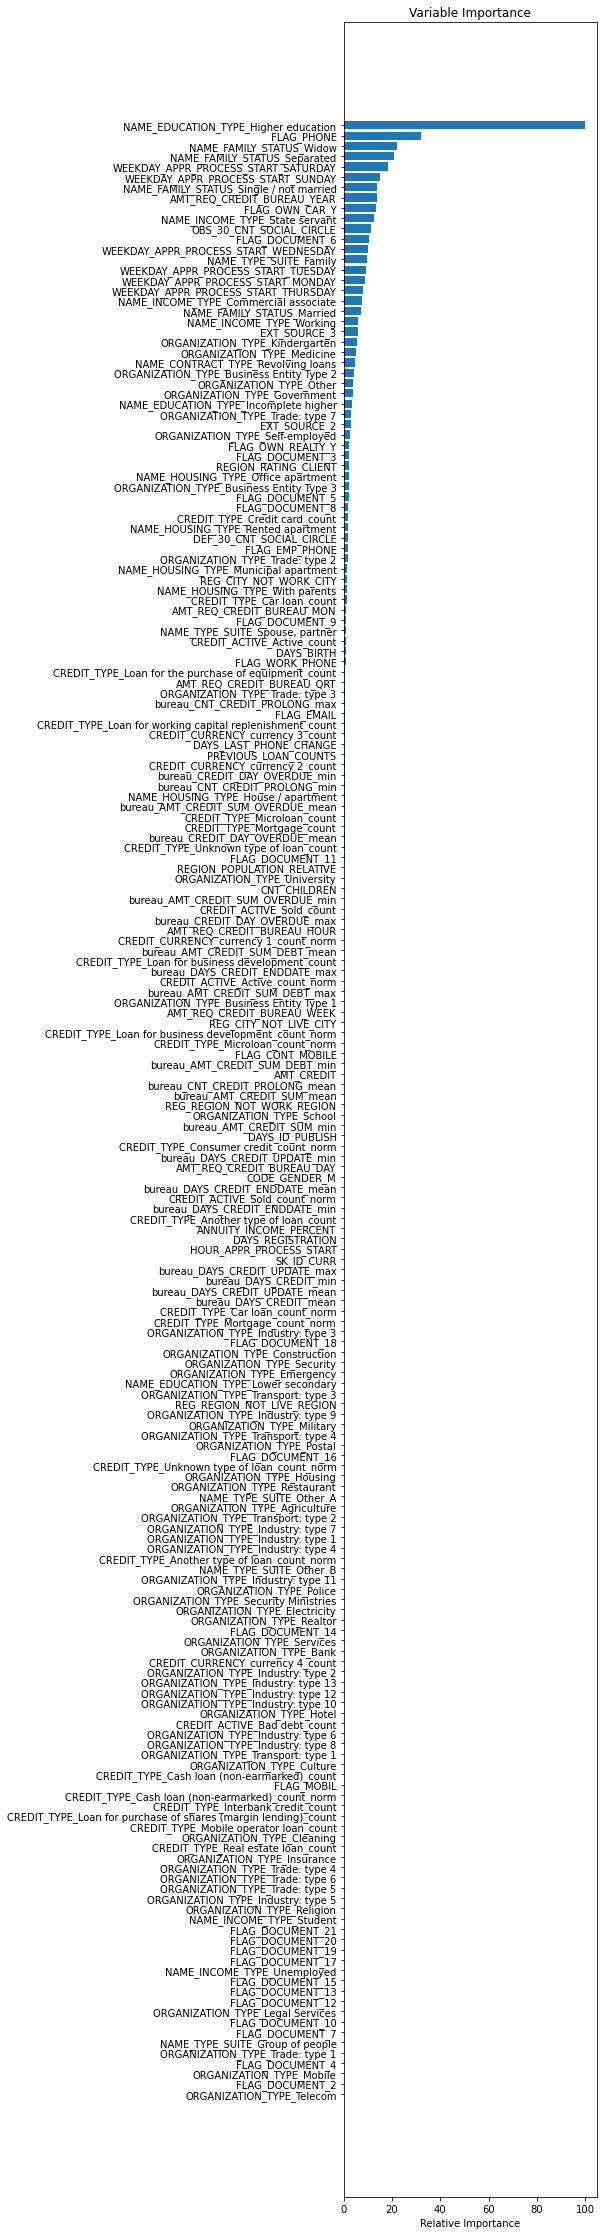

In [191]:
feature_importance = clf.feature_importances_

plt.figure(figsize= (10,40))
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [192]:
xgb_smoted_importances = pd.DataFrame(clf.feature_importances_, X.columns)
xgb_smoted_importances = xgb_smoted_importances.sort_values(by=0, ascending=False)
xgb_smoted_importances.head(10) #show 15 most important features

,0
NAME_EDUCATION_TYPE_Higher education,0.218824
FLAG_PHONE,0.070228
NAME_FAMILY_STATUS_Widow,0.048652
NAME_FAMILY_STATUS_Separated,0.046030
WEEKDAY_APPR_PROCESS_START_SATURDAY,0.040141
WEEKDAY_APPR_PROCESS_START_SUNDAY,0.032716
NAME_FAMILY_STATUS_Single / not married,0.030477
AMT_REQ_CREDIT_BUREAU_YEAR,0.030008
FLAG_OWN_CAR_Y,0.029737
NAME_INCOME_TYPE_State servant,0.027668


In [193]:
xgb_smoted_importances.reset_index(inplace=True)

In [194]:
xgb_smoted_importances.rename(columns = {'index': 'feature', 0: 'importance'}, inplace=True)

In [195]:
xgb_smoted_importances.head()

,feature,importance
0,NAME_EDUCATION_TYPE_Higher education,0.218824
1,FLAG_PHONE,0.070228
2,NAME_FAMILY_STATUS_Widow,0.048652
3,NAME_FAMILY_STATUS_Separated,0.046030
4,WEEKDAY_APPR_PROCESS_START_SATURDAY,0.040141


### No Smote Balancing

In [192]:
X = df_merged.drop(columns = ['TARGET', 'TYPE_train'])
y = df_merged['TARGET']

In [193]:
params={
    "max_depth"        : [3, 5, 7, 9, 11],
    "min_child_weight" : [1, 3, 5, 7],
    "n_estimators"     : [20, 50, 80, 120, 140],
    "colsample_bytree" : [0.3, 0.6, 0.8, 0.9],
    'subsample'        : [0.3, 0.6, 0.8, 0.9]
}

In [194]:
clf = XGBClassifier(learning_rate=0.01)

random_search = RandomizedSearchCV(clf, param_distributions=params, scoring='recall', n_iter=10, n_jobs=-1, random_state=42, iid=False, cv=3, verbose=3)

start_time=timer(None)

random_search.fit(X, y)

timer(start_time)


 Time taken: 0 hours 13 minutes and 36.82 seconds.
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 68.8min finished


In [291]:
random_search.best_params_, random_search.best_score_

({'subsample': 0.8,
  'n_estimators': 140,
  'min_child_weight': 7,
  'max_depth': 7,
  'colsample_bytree': 0.8},
 0.001677606367644267)

In [195]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=11,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=None)

In [197]:
clf = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=11,
              min_child_weight=7, missing=None, monotone_constraints=None,
              n_estimators=120, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=None)

clf.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=11,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=120, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.6, tree_method=None,
              validate_parameters=False, verbosity=None)

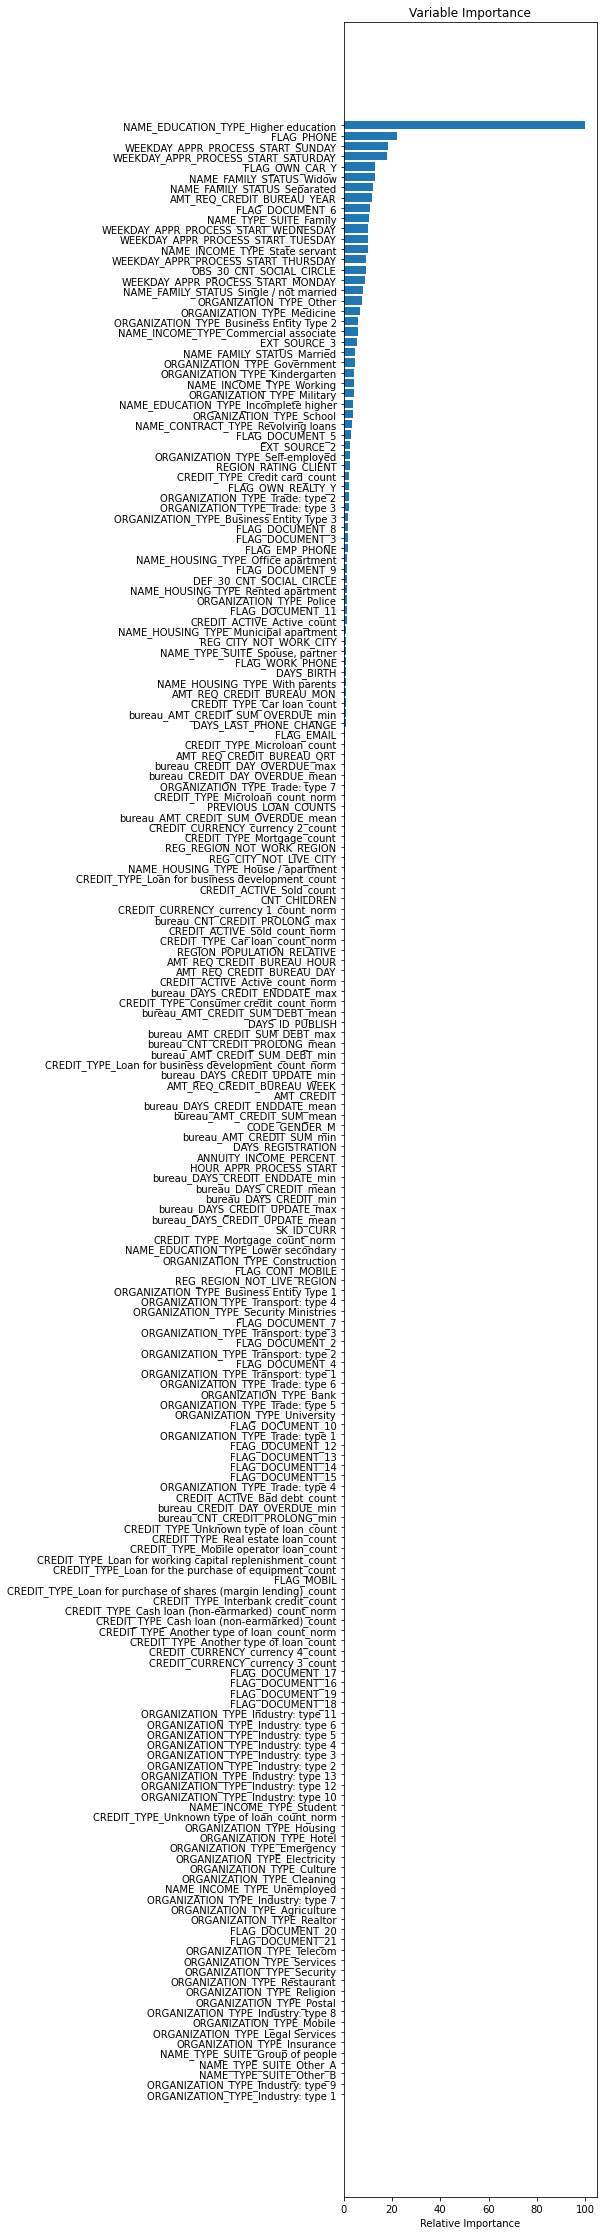

In [198]:
feature_importance = clf.feature_importances_

plt.figure(figsize= (10,40))
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [200]:
xgb_imbalanced_importances = pd.DataFrame(clf.feature_importances_, X.columns)
xgb_imbalanced_importances = xgb_imbalanced_importances.sort_values(by=0, ascending=False)
xgb_imbalanced_importances.head(10) #show 15 most important features

,0
NAME_EDUCATION_TYPE_Higher education,0.236579
FLAG_PHONE,0.052652
WEEKDAY_APPR_PROCESS_START_SUNDAY,0.043950
WEEKDAY_APPR_PROCESS_START_SATURDAY,0.042365
FLAG_OWN_CAR_Y,0.031153
NAME_FAMILY_STATUS_Widow,0.030839
NAME_FAMILY_STATUS_Separated,0.028670
AMT_REQ_CREDIT_BUREAU_YEAR,0.027715
FLAG_DOCUMENT_6,0.026138
NAME_TYPE_SUITE_Family,0.025329


### Averaging feature importances for our two best models

In [201]:
combined_importances = pd.merge(rfm_smoted_importances, xgb_smoted_importances, on='feature', how='left')

In [202]:
combined_importances.head()

,feature,importance_x,importance_y
0,EXT_SOURCE_3,0.108365,0.013061
1,NAME_EDUCATION_TYPE_Higher education,0.084780,0.218824
2,EXT_SOURCE_2,0.076864,0.006347
3,FLAG_OWN_CAR_Y,0.067115,0.029737
4,FLAG_PHONE,0.063952,0.070228


In [203]:
combined_importances['avg_importance'] = (combined_importances['importance_x'] + combined_importances['importance_y']) / 2

In [204]:
combined_importances.head()

,feature,importance_x,importance_y,avg_importance
0,EXT_SOURCE_3,0.108365,0.013061,0.060713
1,NAME_EDUCATION_TYPE_Higher education,0.084780,0.218824,0.151802
2,EXT_SOURCE_2,0.076864,0.006347,0.041606
3,FLAG_OWN_CAR_Y,0.067115,0.029737,0.048426
4,FLAG_PHONE,0.063952,0.070228,0.067090


In [205]:
combined_importances.shape

(192, 4)

In [206]:
combined_importances = combined_importances[combined_importances['avg_importance'] >= 0.005]

In [207]:
combined_importances.shape

(36, 4)

In [208]:
combined_importance_features = list(combined_importances.feature.values)

### Random Forest with Average Importances

In [209]:
X = df_merged.drop(columns = ['TARGET', 'TYPE_train'])
y = df_merged['TARGET']

In [239]:
X = X[combined_importance_features]

X.head()

,EXT_SOURCE_3,NAME_EDUCATION_TYPE_Higher education,EXT_SOURCE_2,FLAG_OWN_CAR_Y,FLAG_PHONE,AMT_REQ_CREDIT_BUREAU_YEAR,OBS_30_CNT_SOCIAL_CIRCLE,NAME_FAMILY_STATUS_Married,NAME_INCOME_TYPE_Commercial associate,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,FLAG_OWN_REALTY_Y,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,DAYS_BIRTH,CREDIT_TYPE_Credit card_count,NAME_TYPE_SUITE_Family,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,ORGANIZATION_TYPE_Business Entity Type 3,WEEKDAY_APPR_PROCESS_START_SATURDAY,NAME_HOUSING_TYPE_House / apartment,NAME_FAMILY_STATUS_Single / not married,DEF_30_CNT_SOCIAL_CIRCLE,CREDIT_ACTIVE_Active_count,NAME_INCOME_TYPE_State servant,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Widow,REGION_RATING_CLIENT,NAME_CONTRACT_TYPE_Revolving loans,NAME_INCOME_TYPE_Working,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Medicine,WEEKDAY_APPR_PROCESS_START_SUNDAY,ORGANIZATION_TYPE_Kindergarten
0,0.139376,0,0.262949,0,1,1.0,2.0,0,0,1,0,1,0,0,9461,0.0,0,0,0,1,0,1,1,2.0,1.0,0,0,0,2,0,1,0,0,0,0,0
1,0.729567,0,0.555912,1,1,0.0,0.0,0,0,0,0,1,0,1,19046,0.0,0,0,1,0,0,1,1,0.0,0.0,0,0,0,2,1,1,0,0,0,0,0
2,0.621226,0,0.354225,0,1,1.0,0.0,1,0,1,0,1,0,0,16941,0.0,0,0,1,0,0,1,0,0.0,1.0,1,0,0,2,0,0,0,1,0,0,0
3,0.492060,1,0.724000,1,1,2.0,1.0,1,1,0,0,1,0,0,13778,1.0,0,0,0,1,0,1,0,0.0,2.0,0,0,0,2,0,0,0,0,0,1,0
4,0.540654,1,0.714279,1,0,0.0,2.0,1,0,0,0,1,0,1,18850,0.0,0,0,1,0,0,1,0,0.0,1.0,1,0,0,3,0,0,0,1,0,0,0


In [211]:
X.shape

(236630, 36)

In [212]:
# Balance data

sm = SMOTE(random_state = 42, sampling_strategy = 'not majority')
X, y = sm.fit_resample(X, y)

In [213]:
params={
    "max_depth"        : [2, 3, 4],
    "min_samples_split" : [2, 10, 200, 800, 1000],
    "max_leaf_nodes"     : [10, 20, 25, 30],
    "min_samples_leaf" : [1, 10, 100, 250, 500, 1000],
    'n_estimators'        : [20, 30, 40, 100],
    'max_samples': [0.2, 0.6, 1.0]
}

In [214]:
clf = RandomForestClassifier()

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=10, scoring='recall', iid=False, n_jobs=-1, random_state=42, cv=5, verbose=3)

start_time = timer(None)

random_search.fit(X, y)

timer(start_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.4s finished



 Time taken: 0 hours 0 minutes and 36.23 seconds.


In [215]:
random_search.best_params_, random_search.best_score_

({'n_estimators': 20,
  'min_samples_split': 10,
  'min_samples_leaf': 500,
  'max_samples': 0.6,
  'max_leaf_nodes': 20,
  'max_depth': 4},
 0.8459882207721305)

Hyperparameter tuning...

In [218]:
params={
    'n_estimators'        : [10, 15, 20, 25],
    "min_samples_split" : [8, 9, 10, 11, 12],
    "min_samples_leaf" : [400, 450, 500, 550, 600],
    'max_samples': [0.5, 0.6, 0.7],
    "max_leaf_nodes"     : [10, 15, 20, 25],
    "max_depth"        : [4, 5, 6]
}

In [219]:
clf = RandomForestClassifier()

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=25, scoring='recall', iid=False, n_jobs=-1, random_state=42, cv=5, verbose=3)

start_time = timer(None)

random_search.fit(X, y)

timer(start_time)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.7min finished



 Time taken: 0 hours 1 minutes and 47.23 seconds.


In [220]:
random_search.best_params_, random_search.best_score_

({'n_estimators': 25,
  'min_samples_split': 10,
  'min_samples_leaf': 600,
  'max_samples': 0.7,
  'max_leaf_nodes': 25,
  'max_depth': 5},
 0.8462449854961378)

In [221]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=25, max_samples=0.7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=600, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [222]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=25, max_samples=0.7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=400, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42,
                       verbose=0, warm_start=False)

clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=25, max_samples=0.7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=400, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

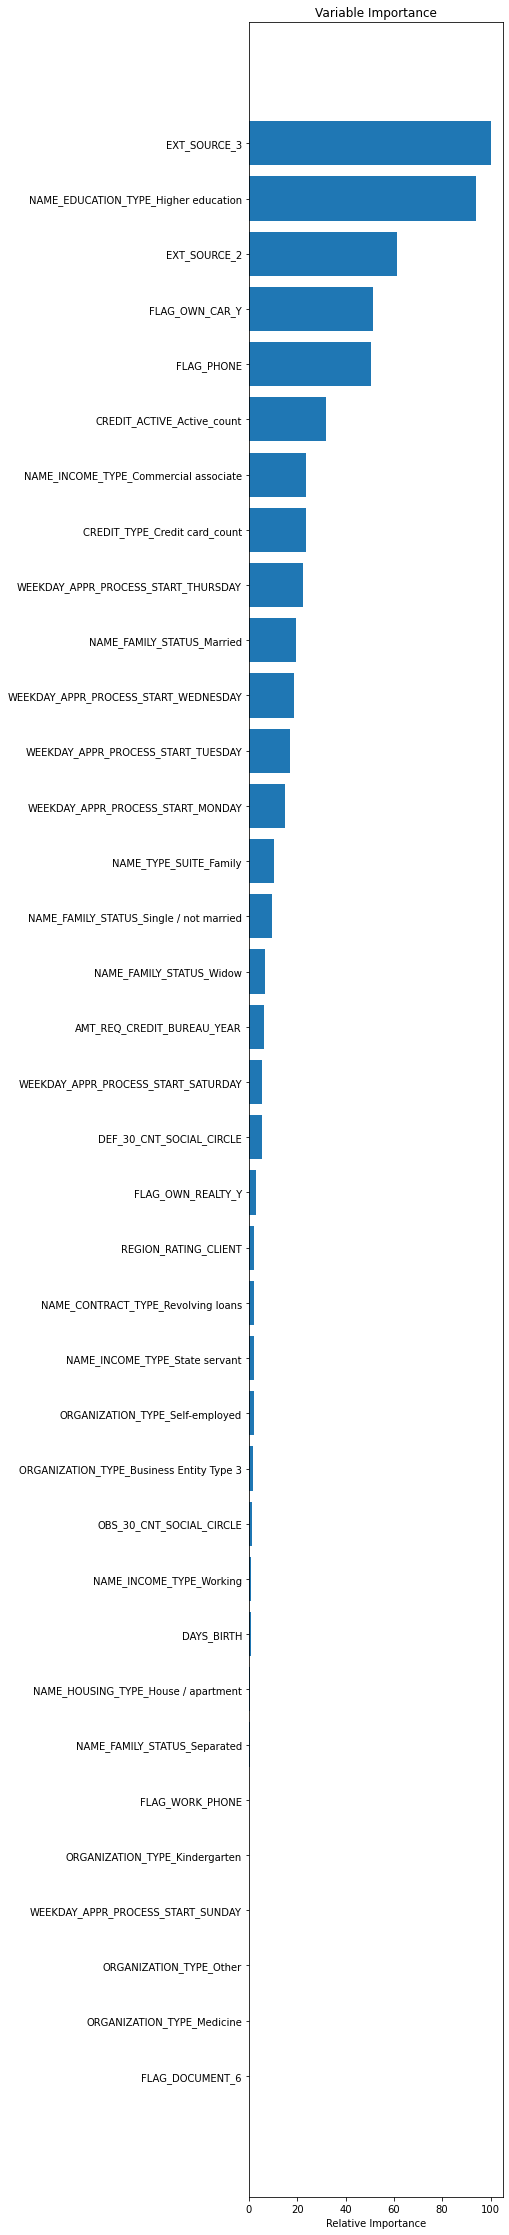

In [223]:
feature_importance = clf.feature_importances_

plt.figure(figsize= (10,40))
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [224]:
rfm_combined_importances = pd.DataFrame(clf.feature_importances_, X.columns)
rfm_combined_importances = rfm_combined_importances.sort_values(by=0, ascending=False)
rfm_combined_importances.head(10) #show 15 most important features

,0
EXT_SOURCE_3,0.170087
NAME_EDUCATION_TYPE_Higher education,0.159714
EXT_SOURCE_2,0.104297
FLAG_OWN_CAR_Y,0.087509
FLAG_PHONE,0.086219
CREDIT_ACTIVE_Active_count,0.053919
NAME_INCOME_TYPE_Commercial associate,0.040521
CREDIT_TYPE_Credit card_count,0.039979
WEEKDAY_APPR_PROCESS_START_THURSDAY,0.037836
NAME_FAMILY_STATUS_Married,0.033221


### XGBoost with Average Importances

In [225]:
X = df_merged.drop(columns = ['TARGET', 'TYPE_train'])
y = df_merged['TARGET']

In [226]:
X = X[combined_importance_features]



In [227]:
# Balance data

sm = SMOTE(random_state = 42, sampling_strategy = 'not majority')
X, y = sm.fit_resample(X, y)

In [228]:
params={
    "max_depth"        : [3, 5, 7, 9, 11],
    "min_child_weight" : [1, 3, 5, 7],
    "n_estimators"     : [20, 50, 80, 120, 140],
    "colsample_bytree" : [0.3, 0.6, 0.8, 0.9],
    'subsample'        : [0.3, 0.6, 0.8, 0.9]
}

In [229]:
clf = XGBClassifier(learning_rate=0.01, random_state = 42)

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=15, scoring='recall', n_jobs=-1, iid=False, cv=5, verbose=3)

start_time=timer(None)

random_search.fit(X, y)

timer(start_time)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 12.8min finished



 Time taken: 0 hours 13 minutes and 25.99 seconds.


In [234]:
random_search.best_params_, random_search.best_score_

({'subsample': 0.8,
  'n_estimators': 140,
  'min_child_weight': 5,
  'max_depth': 9,
  'colsample_bytree': 0.6},
 0.9019500893909775)

In [235]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [236]:
clf = XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=5, missing=None, monotone_constraints=None,
              n_estimators=140, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

clf.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

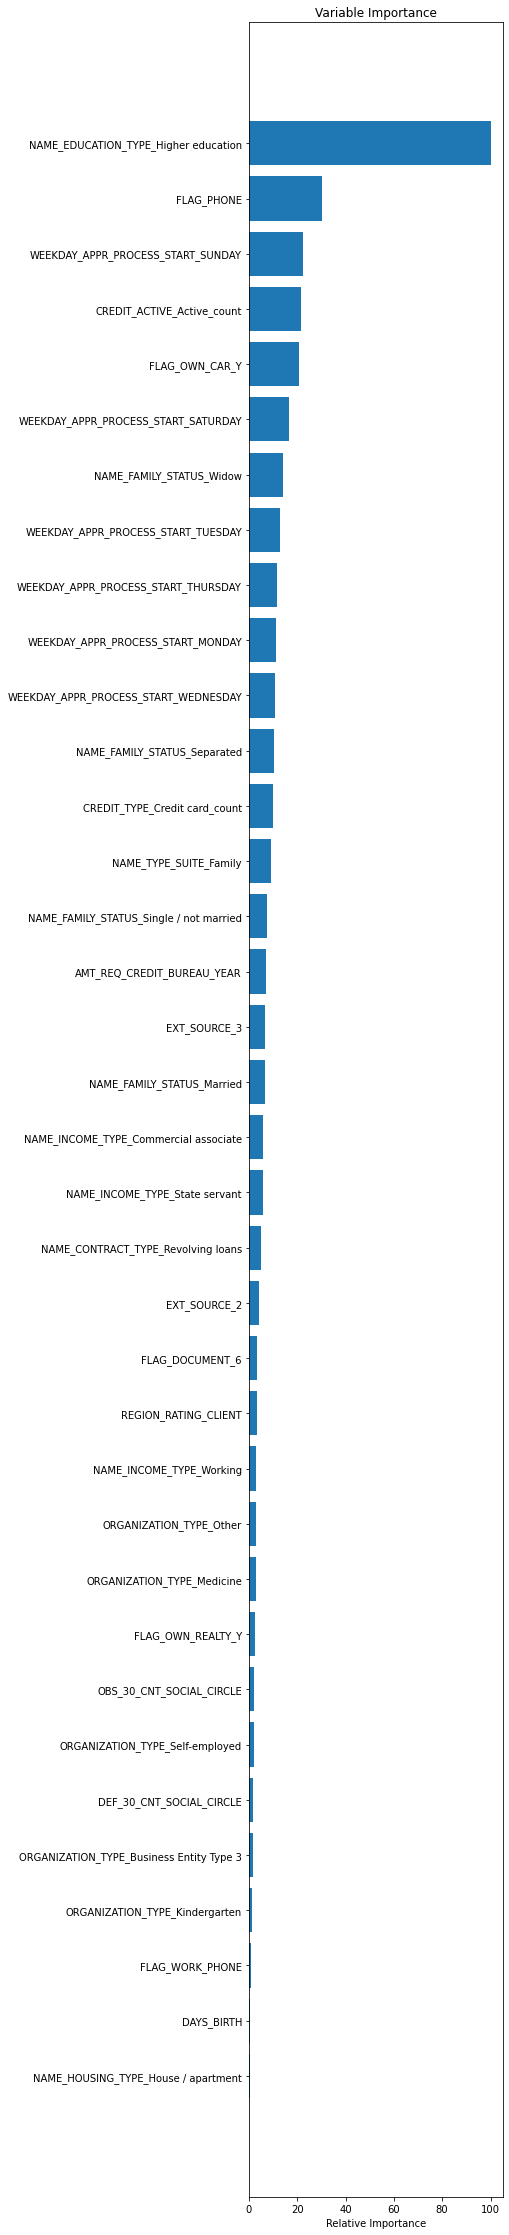

In [237]:
feature_importance = clf.feature_importances_

plt.figure(figsize= (10,40))
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [238]:
xgb_combined_importances = pd.DataFrame(clf.feature_importances_, X.columns)
xgb_combined_importances = xgb_combined_importances.sort_values(by=0, ascending=False)
xgb_combined_importances.head(10) #show 15 most important features

,0
NAME_EDUCATION_TYPE_Higher education,0.263746
FLAG_PHONE,0.079495
WEEKDAY_APPR_PROCESS_START_SUNDAY,0.058819
CREDIT_ACTIVE_Active_count,0.056422
FLAG_OWN_CAR_Y,0.055086
WEEKDAY_APPR_PROCESS_START_SATURDAY,0.043216
NAME_FAMILY_STATUS_Widow,0.036928
WEEKDAY_APPR_PROCESS_START_TUESDAY,0.033837
WEEKDAY_APPR_PROCESS_START_THURSDAY,0.030521
WEEKDAY_APPR_PROCESS_START_MONDAY,0.029636


# Concluding Thoughts

For the modeling phase, we ran random forest, logistic regression and gradient boosting models with and without SMOTE-balancing. We then averaged the feature importances of the best-performing models for which feature importances are obtainable: random forest and xgboost. We set a cut-off point for importances and dropped all features below them. Finally, we modeled the remaining features using SMOTE-balanced random forest and xgboost algorithms, conducting hyperparameter tuning throughout.

I decided to optimize our models for recall, given that it is in the interest of loan business operators to reduce type II error, a.k.a. incorrectly concluding a client will have no trouble paying back their loans. Reducing type II error will reduce payment delays and loan defaults.

Optimizing for recall, the best performing model overall was the SMOTE-balanced XGBoost algorithm which included all features, with a score of 92.61%. However, the SMOTE-balanced XGBoost algorithm with reduced dimensionality performed almost as well at 90.44% and with a much smaller dataset. In a real world setting, a desire for efficiency and speed when evaluating credit risk might mean choosing the reduced dataset, even if it has a slightly lower recall score. However, if the compute cost needed to model the full dataset is lower than or equal to the financial gain from assessing an additional 2.16% of clients correctly, the first algorithm would be the best choice.

Under the assumption that we pick the more efficient, reduced dataset, the most important predictors of ease or difficulty paying loans are whether the client:

    1. Has completed higher education,
    2. Owns a phone,
    3. Applied for the loan on Sunday,
    4. Has active external loans,
    5. Owns a car. 
    
The third factor might be unexpectedly important on the one hand, or give us cause to be wary of the results of our algorithm on the other. Overall, the results give us insight into what to look for when evaluating a client's creditworthiness.
   
There are many things we could do to improve this supervised learning experiment. We could run other models, such as KNN and SVC. Precision-recall curves could be added for illustrative purposes. We could conduct more feature engineering on our dataset. Most of all, I would really like to make a Streamlit app for this project, where you could operate as a HomeCredit employee, input datapoints about a fictitious loan applicant, and get a probability that that applicant would have difficulty paying his or her loan back, along with recall scores.